In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import gridspec
from datetime import datetime
from scipy import interpolate
from scipy import integrate
import scipy.stats
import numpy.ma as ma
import numpy as np
from matplotlib import gridspec
import warnings
warnings.filterwarnings(action='ignore')
from scipy.stats import kde
import trackpy as tp
import glob
import os
import rasterio
import seaborn as sns
import pims
dem_files = sorted(glob.glob('/data/accp/a/snesbitt/relampago/srtm/*.tif'))
ds_list = []
for file in dem_files:
   ds_list.append(xr.open_rasterio(file).isel(band=0))
import metpy.calc as mpcalc
from metpy.units import units
from geopy import distance


In [14]:
gpd_jan25 = pd.read_csv('/data/keeling/a/melinda3/accp/tracking_ots/ot_trajectories_trackpy_filtered6.csv')
gpd_jan25
 

,Unnamed: 0.1,Unnamed: 0,time,lat,lon,lat_corr,lon_corr,otid,mintb,tropopause_height,...,diff,frame,states,label,x,y,date,hour,particle,cell
0,3914,0,2018-11-05 00:00:57.000000512,-33.508930,-64.508934,-33.388930,-64.548935,15.0,204.25000,15.821001,...,4 days 00:00:57.000000512,0,0,0,-186252.771818,-113957.182952,2018-11-05,0,0,1.0
1,3915,1,2018-11-05 00:00:57.000000512,-34.330357,-65.562500,-34.205357,-65.599500,37.0,201.95000,14.893001,...,4 days 00:00:57.000000512,0,0,0,-281195.211761,-207614.473616,2018-11-05,0,1,2.0
2,3916,2,2018-11-05 00:00:57.000000512,-34.812500,-65.241070,-34.688500,-65.279076,64.0,203.19000,14.362000,...,4 days 00:00:57.000000512,0,0,0,-250256.683854,-260397.992068,2018-11-05,0,2,3.0
3,3917,3,2018-11-05 00:01:57.000000512,-33.491070,-64.526790,-33.373070,-64.566790,17.0,205.31999,15.824000,...,4 days 00:01:57.000000512,60,0,0,-187946.438440,-112002.942262,2018-11-05,0,0,1.0
4,3918,4,2018-11-05 00:01:57.000000512,-34.348217,-65.580350,-34.222218,-65.617355,38.0,201.65999,14.882001,...,4 days 00:01:57.000000512,60,0,0,-282773.895291,-209647.669965,2018-11-05,0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30223,12497,16,2019-02-11 05:49:21.000000512,-30.866072,-64.276790,-30.744072,-64.321785,2.0,189.37999,16.827002,...,102 days 05:49:21.000000512,8488104,0,0,-169598.851512,180287.613917,2019-02-11,5,8416,NaN
30224,12498,17,2019-02-11 06:55:20.999999488,-31.062498,-61.991070,-30.939499,-62.045070,7.0,190.01999,16.798000,...,102 days 06:55:20.999999488,8492063,0,0,48480.905512,159729.906504,2019-02-11,6,8417,NaN
30225,12499,18,2019-02-11 06:56:21.000000512,-30.883930,-62.294647,-30.762930,-62.347650,4.0,191.06000,16.823000,...,102 days 06:56:21.000000512,8492124,0,0,19599.155073,179680.596664,2019-02-11,6,8418,NaN
30226,12500,19,2019-02-11 09:05:20.999999488,-30.883930,-60.401787,-30.764930,-60.460785,2.0,192.03000,16.690000,...,102 days 09:05:20.999999488,8499863,0,0,200235.892144,177750.897733,2019-02-11,9,8419,8420.0


In [15]:
times = gpd_jan25.time
hours = []
months = []
for time in times:
   test = datetime.strptime(time[0:19], '%Y-%m-%d %H:%M:%S')
   hours.append(test.hour)
   months.append(test.month)

In [16]:
times_dt = pd.to_datetime(times)
gpd_jan25.index = times_dt
st_times = gpd_jan25.index.strftime('%Y-%m-%d %H:%M:%S')
gpd_jan25['time_conv'] = st_times

In [17]:
#gpd_jan25['count'] = gpd_jan25['cell'].transform('nunique')
#trajectories_filtered['size'] = trajectories_filtered.groupby(['cell']).transform(np.size)
gpd_jan25['duration'] = gpd_jan25['cell'].map(gpd_jan25['cell'].value_counts())
gpd_jan25['hours'] = hours
gpd_jan25['month'] = months
gpd_jan25 = gpd_jan25.dropna(subset=['cell'])
gpd_jan25['mintbc'] = gpd_jan25['mintb'] - 273.15
gpd_jan25['dz_lowest_6'] = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_lowest'])/-6
#gpd_jan25 = gpd_jan25.set_index('time')

In [18]:
gpd_jan25[gpd_jan25.dz_lowest_6 < 0]

,Unnamed: 0.1,Unnamed: 0,time,lat,lon,lat_corr,lon_corr,otid,mintb,tropopause_height,...,date,hour,particle,cell,time_conv,duration,hours,month,mintbc,dz_lowest_6
time,,,,,,,,,,,,,,,,,,,,,
2018-11-11 01:23:55.000000512,13081,579,2018-11-11 01:23:55.000000512,-32.133930,-64.562500,-32.015930,-64.603500,17.0,201.89000,16.782001,...,2018-11-11,1,444,445.0,2018-11-11 01:23:55,3.0,1,11,-71.26000,-0.085804
2018-11-12 05:01:54.000000000,15849,1778,2018-11-12 05:01:54.000000000,-31.562500,-64.669650,-31.453500,-64.707650,142.0,197.45000,15.965001,...,2018-11-12,5,1145,1146.0,2018-11-12 05:01:54,2.0,5,11,-75.70000,-0.048043
2018-11-12 05:02:54.000000000,15856,1785,2018-11-12 05:02:54.000000000,-31.580357,-64.669650,-31.471357,-64.707650,143.0,197.48000,15.968000,...,2018-11-12,5,1145,1146.0,2018-11-12 05:02:54,2.0,5,11,-75.67000,-0.002903
2018-11-12 09:27:54.000000000,16901,2830,2018-11-12 09:27:54.000000000,-30.473213,-60.562504,-30.305214,-60.646503,70.0,188.95000,24.525002,...,2018-11-12,9,1421,1422.0,2018-11-12 09:27:54,3.0,9,11,-84.20000,-0.021176
2018-11-12 09:28:54.000000000,16905,2834,2018-11-12 09:28:54.000000000,-30.473213,-60.526787,-30.308212,-60.608788,62.0,189.65000,24.274002,...,2018-11-12,9,1421,1422.0,2018-11-12 09:28:54,3.0,9,11,-83.50000,-0.144001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-30 06:11:53.000000512,31383,7,2019-01-30 06:11:53.000000512,-31.955359,-63.473213,-31.842358,-63.516212,72.0,199.15999,16.419000,...,2019-01-30,6,8134,8135.0,2019-01-30 06:11:53,2.0,6,1,-73.99001,-0.033404
2019-01-30 06:12:52.999999488,31387,11,2019-01-30 06:12:52.999999488,-31.955359,-63.455353,-31.841358,-63.499350,64.0,198.72000,16.415000,...,2019-01-30,6,8134,8135.0,2019-01-30 06:12:52,2.0,6,1,-74.43000,-0.271074
2019-01-30 07:09:52.999999488,31418,42,2019-01-30 07:09:52.999999488,-31.169643,-63.669643,-31.060644,-63.711643,36.0,199.09999,16.326000,...,2019-01-30,7,8146,8147.0,2019-01-30 07:09:52,4.0,7,1,-74.05001,-0.085400


In [19]:
gpd_jan25 = gpd_jan25[gpd_jan25.area_polygon > 4 ]
gpd_jan25 = gpd_jan25[gpd_jan25.lapse_rate > -9999]
gpd_jan25 = gpd_jan25[gpd_jan25.n2 > -9999]
#gpd_jan25 = gpd_jan25[gpd_jan25.ot_depth < 7]
gpd_jan25 = gpd_jan25[gpd_jan25.dz_lowest_6 > 0]


In [13]:
gpd_jan25

,Unnamed: 0.1,Unnamed: 0,time,lat,lon,lat_corr,lon_corr,otid,mintb,tropopause_height,...,date,hour,particle,cell,time_conv,duration,hours,month,mintbc,dz_lowest_6
time,,,,,,,,,,,,,,,,,,,,,
2018-11-05 00:00:57.000000512,3914,0,2018-11-05 00:00:57.000000512,-33.508930,-64.508934,-33.388930,-64.548935,15.0,204.25000,15.821001,...,2018-11-05,0,0,1.0,2018-11-05 00:00:57,2.0,0,11,-68.90000,0.425758
2018-11-05 00:00:57.000000512,3915,1,2018-11-05 00:00:57.000000512,-34.330357,-65.562500,-34.205357,-65.599500,37.0,201.95000,14.893001,...,2018-11-05,0,1,2.0,2018-11-05 00:00:57,3.0,0,11,-71.20000,2.199936
2018-11-05 00:00:57.000000512,3916,2,2018-11-05 00:00:57.000000512,-34.812500,-65.241070,-34.688500,-65.279076,64.0,203.19000,14.362000,...,2018-11-05,0,2,3.0,2018-11-05 00:00:57,3.0,0,11,-69.96000,1.945950
2018-11-05 00:01:57.000000512,3917,3,2018-11-05 00:01:57.000000512,-33.491070,-64.526790,-33.373070,-64.566790,17.0,205.31999,15.824000,...,2018-11-05,0,0,1.0,2018-11-05 00:01:57,2.0,0,11,-67.83001,0.242796
2018-11-05 00:01:57.000000512,3918,4,2018-11-05 00:01:57.000000512,-34.348217,-65.580350,-34.222218,-65.617355,38.0,201.65999,14.882001,...,2018-11-05,0,1,2.0,2018-11-05 00:01:57,3.0,0,11,-71.49001,2.250677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-11 04:57:20.999999488,12493,12,2019-02-11 04:57:20.999999488,-31.258928,-64.633934,-31.136929,-64.676930,4.0,191.76999,16.865002,...,2019-02-11,4,8414,8415.0,2019-02-11 04:57:20,7.0,4,2,-81.38001,1.861617
2019-02-11 04:58:20.999999488,12495,14,2019-02-11 04:58:20.999999488,-31.258928,-64.616066,-31.136929,-64.659065,4.0,191.92000,16.864000,...,2019-02-11,4,8414,8415.0,2019-02-11 04:58:20,7.0,4,2,-81.23000,1.837606
2019-02-11 04:59:20.999999488,12496,15,2019-02-11 04:59:20.999999488,-31.258928,-64.616066,-31.138927,-64.658066,4.0,193.54000,16.867000,...,2019-02-11,4,8414,8415.0,2019-02-11 04:59:20,7.0,4,2,-79.61000,1.567606


In [20]:
grouped_ots = gpd_jan25.groupby(gpd_jan25.cell)

In [21]:
time_delta = []
otids = np.unique(list(grouped_ots.keys))
for id in otids:
    time = grouped_ots.get_group(id).index
    time_end = time[-1].round(freq='s')
    time_s = time[0].round(freq='s')
    duration = (time_end - time_s)
    time_delta.append(pd.Timedelta(duration, dtype='m'))

In [22]:
td_mins = [tdm.components.minutes for tdm in time_delta]


In [23]:
#Calculate track length and plot it against track duration
dist_km = []
for id in otids:
    lat = grouped_ots.get_group(id).lat
    lon = grouped_ots.get_group(id).lon

    lat_s = lat[0]
    lat_f = lat[-1]
    lon_s = lon[0]
    lon_f = lon[-1]
    start = (lat_s, lon_s)
    end = (lat_f, lon_f)
    dist = (distance.distance(start, end).km)
    dist_km.append(dist)

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35'),
  Text(0, 40.0, '40'),
  Text(0, 45.0, '45')])

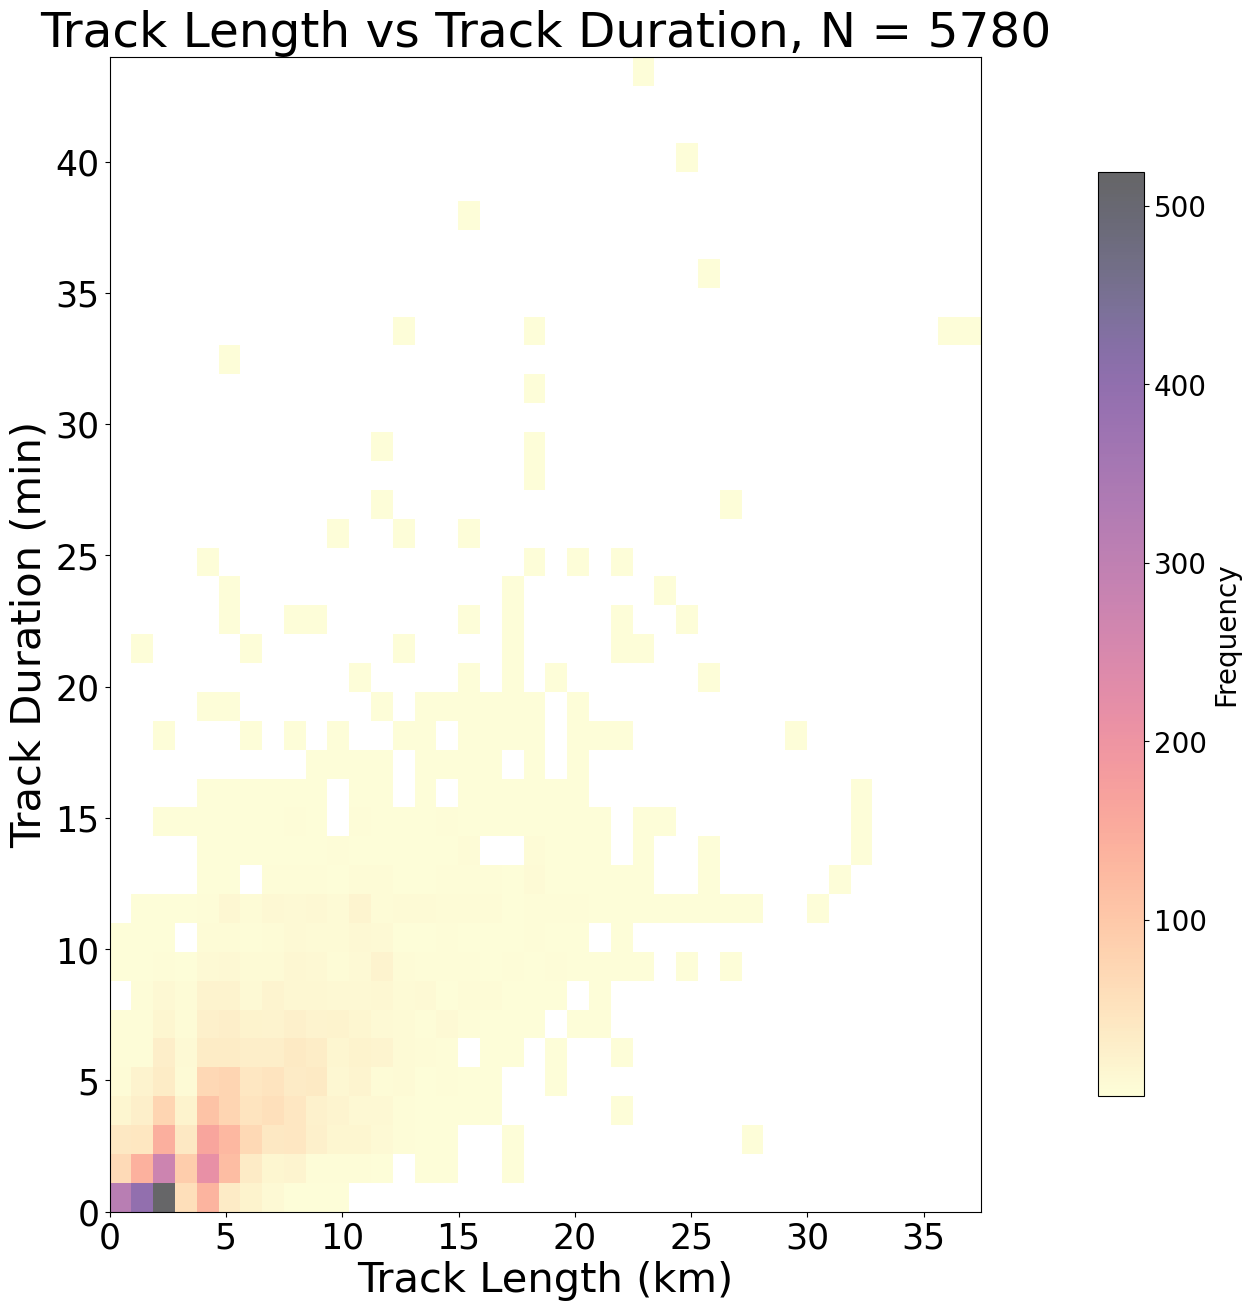

In [56]:
#Create a 2D histogram of distance vs duration
len_all = len(gpd_jan25)
fig, ax = plt.subplots(1,1,figsize = (15,15))
c,x,y, im5 = ax.hist2d(dist_km, td_mins, bins = (40,40), cmap = rev_map, cmin = 1., cmax = 700., alpha = 0.6)
cb1 = plt.colorbar(im5,shrink=0.8, pad=0.1)
cb1.set_label('Frequency', fontsize = 20)
cb1.ax.tick_params(labelsize = 20)
plt.title('Track Length vs Track Duration, N = %0.0f'%samples, fontsize = 35)
plt.xlabel('Track Length (km)', fontsize=30)
plt.ylabel('Track Duration (min)', fontsize=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize=25)

In [48]:
og_map = plt.cm.get_cmap('magma')
rev_map = og_map.reversed()

In [49]:
jan25_lapserate = grouped_ots.mean('lapse_rate').lapse_rate
jan25_n2calc = grouped_ots.mean('n2').n2
ota_25jan = grouped_ots.mean('area_polygon').area_polygon
otd_25jan = grouped_ots.mean('dz_lowest_6').dz_lowest_6
#btd = grouped_ots.mean('btd').btd
#w_max = grouped_ots.mean('w').w
mucape = grouped_ots.mean('mucape').mucape
#duration = grouped_ots.duration.nth(0)
filt_dict = {'ota_25jan':ota_25jan, 'otd_25jan':otd_25jan, 'jan25_lapserate':jan25_lapserate, 'jan25_n2calc':jan25_n2calc,
                'mucape':mucape, 'duration':td_mins}
filtered_df = pd.DataFrame(data=filt_dict)

In [50]:
#Calculate the uncertainty in OTA following Davis and Di Girolamo (1997)
a = 4
ota_uncert = (2*a) * np.sqrt((ota_25jan/a)-1)

ota_uncert = np.mean(ota_uncert)

ota_uncert

27.13449413117524

In [51]:
#Calculate the uncertainty in OTD 
dz_pv = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_pv'])/-6
dz_therm = (gpd_jan25['mintbc'] - gpd_jan25['trop_temp_pt'])/-6 

dz_diff = dz_pv.values - dz_therm.values
mean_dz_diff = np.mean(dz_diff)

mean_dz_diff

0.0941843083824554

In [52]:
#Create the OTA bins
bins_ota = np.linspace(min(ota_25jan), max(ota_25jan), 10)
bins_otd = np.linspace(min(otd_25jan), max(otd_25jan), 10)
bins_lapse = np.linspace(min(jan25_lapserate), max(jan25_lapserate), 10)
bins_n2 = np.linspace(min(jan25_n2calc), max(jan25_n2calc), 10)
bins_duration = np.linspace(min(td_mins), max(td_mins),10)
label_otd = bins_otd[:-1]
label_ota = bins_ota[:-1]
label_lapse = bins_lapse[:-1]
label_n2 = bins_n2[:-1]
label_duration = bins_duration[:-1]
labels_ota = list(map(str, label_ota))
labels_otd = list(map(str, label_otd))
labels_lapse = list(map(str, label_lapse))
labels_n2 = list(map(str, label_n2))
labels_duration = list(map(str, label_duration))
filtered_df['ota_bins'] = pd.cut(filtered_df.ota_25jan, bins = bins_ota, labels = labels_ota, right=True, include_lowest=True)
filtered_df['otd_bins'] = pd.cut(filtered_df.otd_25jan, bins = bins_otd, labels = labels_otd, right=True, include_lowest=True)
filtered_df['lapse_bins'] = pd.cut(filtered_df.jan25_lapserate, bins = bins_lapse, labels = labels_lapse, right=True, include_lowest=True)
filtered_df['n2_bins'] = pd.cut(filtered_df.jan25_n2calc, bins = bins_n2, labels = labels_n2, right=True, include_lowest=True)
filtered_df['duration_bins'] = pd.cut(filtered_df.duration, bins = bins_duration, labels = labels_duration, right=True, include_lowest=True)

In [53]:
binned_by_ota = filtered_df.groupby('ota_bins')
ota_binned_ota = binned_by_ota.mean('ota_25jan').ota_25jan
otd_binned_ota = binned_by_ota.mean('ota_25jan').otd_25jan
lapse_binned_ota = binned_by_ota.mean('ota_25jan').jan25_lapserate
n2_binned_ota = binned_by_ota.mean('ota_25jan').jan25_n2calc
duration_binned_ota = binned_by_ota.mean('ota_25jan').duration

binned_by_otd = filtered_df.groupby('otd_bins')
ota_binned_otd = binned_by_otd.mean('otd_25jan').ota_25jan
otd_binned_otd = binned_by_otd.mean('otd_25jan').otd_25jan
lapse_binned_otd = binned_by_otd.mean('otd_25jan').jan25_lapserate
n2_binned_otd = binned_by_otd.mean('otd_25jan').jan25_n2calc
duration_binned_otd = binned_by_otd.mean('otd_25jan').duration

binned_by_duration = filtered_df.groupby('duration_bins')
ota_binned_duration = binned_by_duration.mean('duration').ota_25jan
otd_binned_duration = binned_by_duration.mean('duration').otd_25jan
lapse_binned_duration = binned_by_duration.mean('duration').jan25_lapserate
n2_binned_duration = binned_by_duration.mean('duration').jan25_n2calc
duration_binned_duration = binned_by_duration.mean('duration').duration

binned_by_lapse = filtered_df.groupby('lapse_bins')
ota_binned_lapse = binned_by_lapse.mean('jan25_lapserate').ota_25jan
otd_binned_lapse = binned_by_lapse.mean('jan25_lapserate').otd_25jan
lapse_binned_lapse = binned_by_lapse.mean('jan25_lapserate').jan25_lapserate
n2_binned_lapse = binned_by_lapse.mean('jan25_lapserate').jan25_n2calc
duration_binned_lapse = binned_by_lapse.mean('jan25_lapserate').duration

binned_by_n2 = filtered_df.groupby('n2_bins')
ota_binned_n2 = binned_by_n2.mean('jan25_n2calc').ota_25jan
otd_binned_n2 = binned_by_n2.mean('jan25_n2calc').otd_25jan
lapse_binned_n2 = binned_by_n2.mean('jan25_n2calc').jan25_lapserate
n2_binned_n2 = binned_by_n2.mean('jan25_n2calc').jan25_n2calc
duration_binned_n2 = binned_by_n2.mean('jan25_n2calc').duration

In [54]:
bin_lengths_ota = binned_by_ota.size()
bin_lengths_normed_ota = bin_lengths_ota/max(bin_lengths_ota)
bin_lengths_ott = binned_by_duration.size()
bin_lengths_normed_ott = bin_lengths_ott/max(bin_lengths_ott)

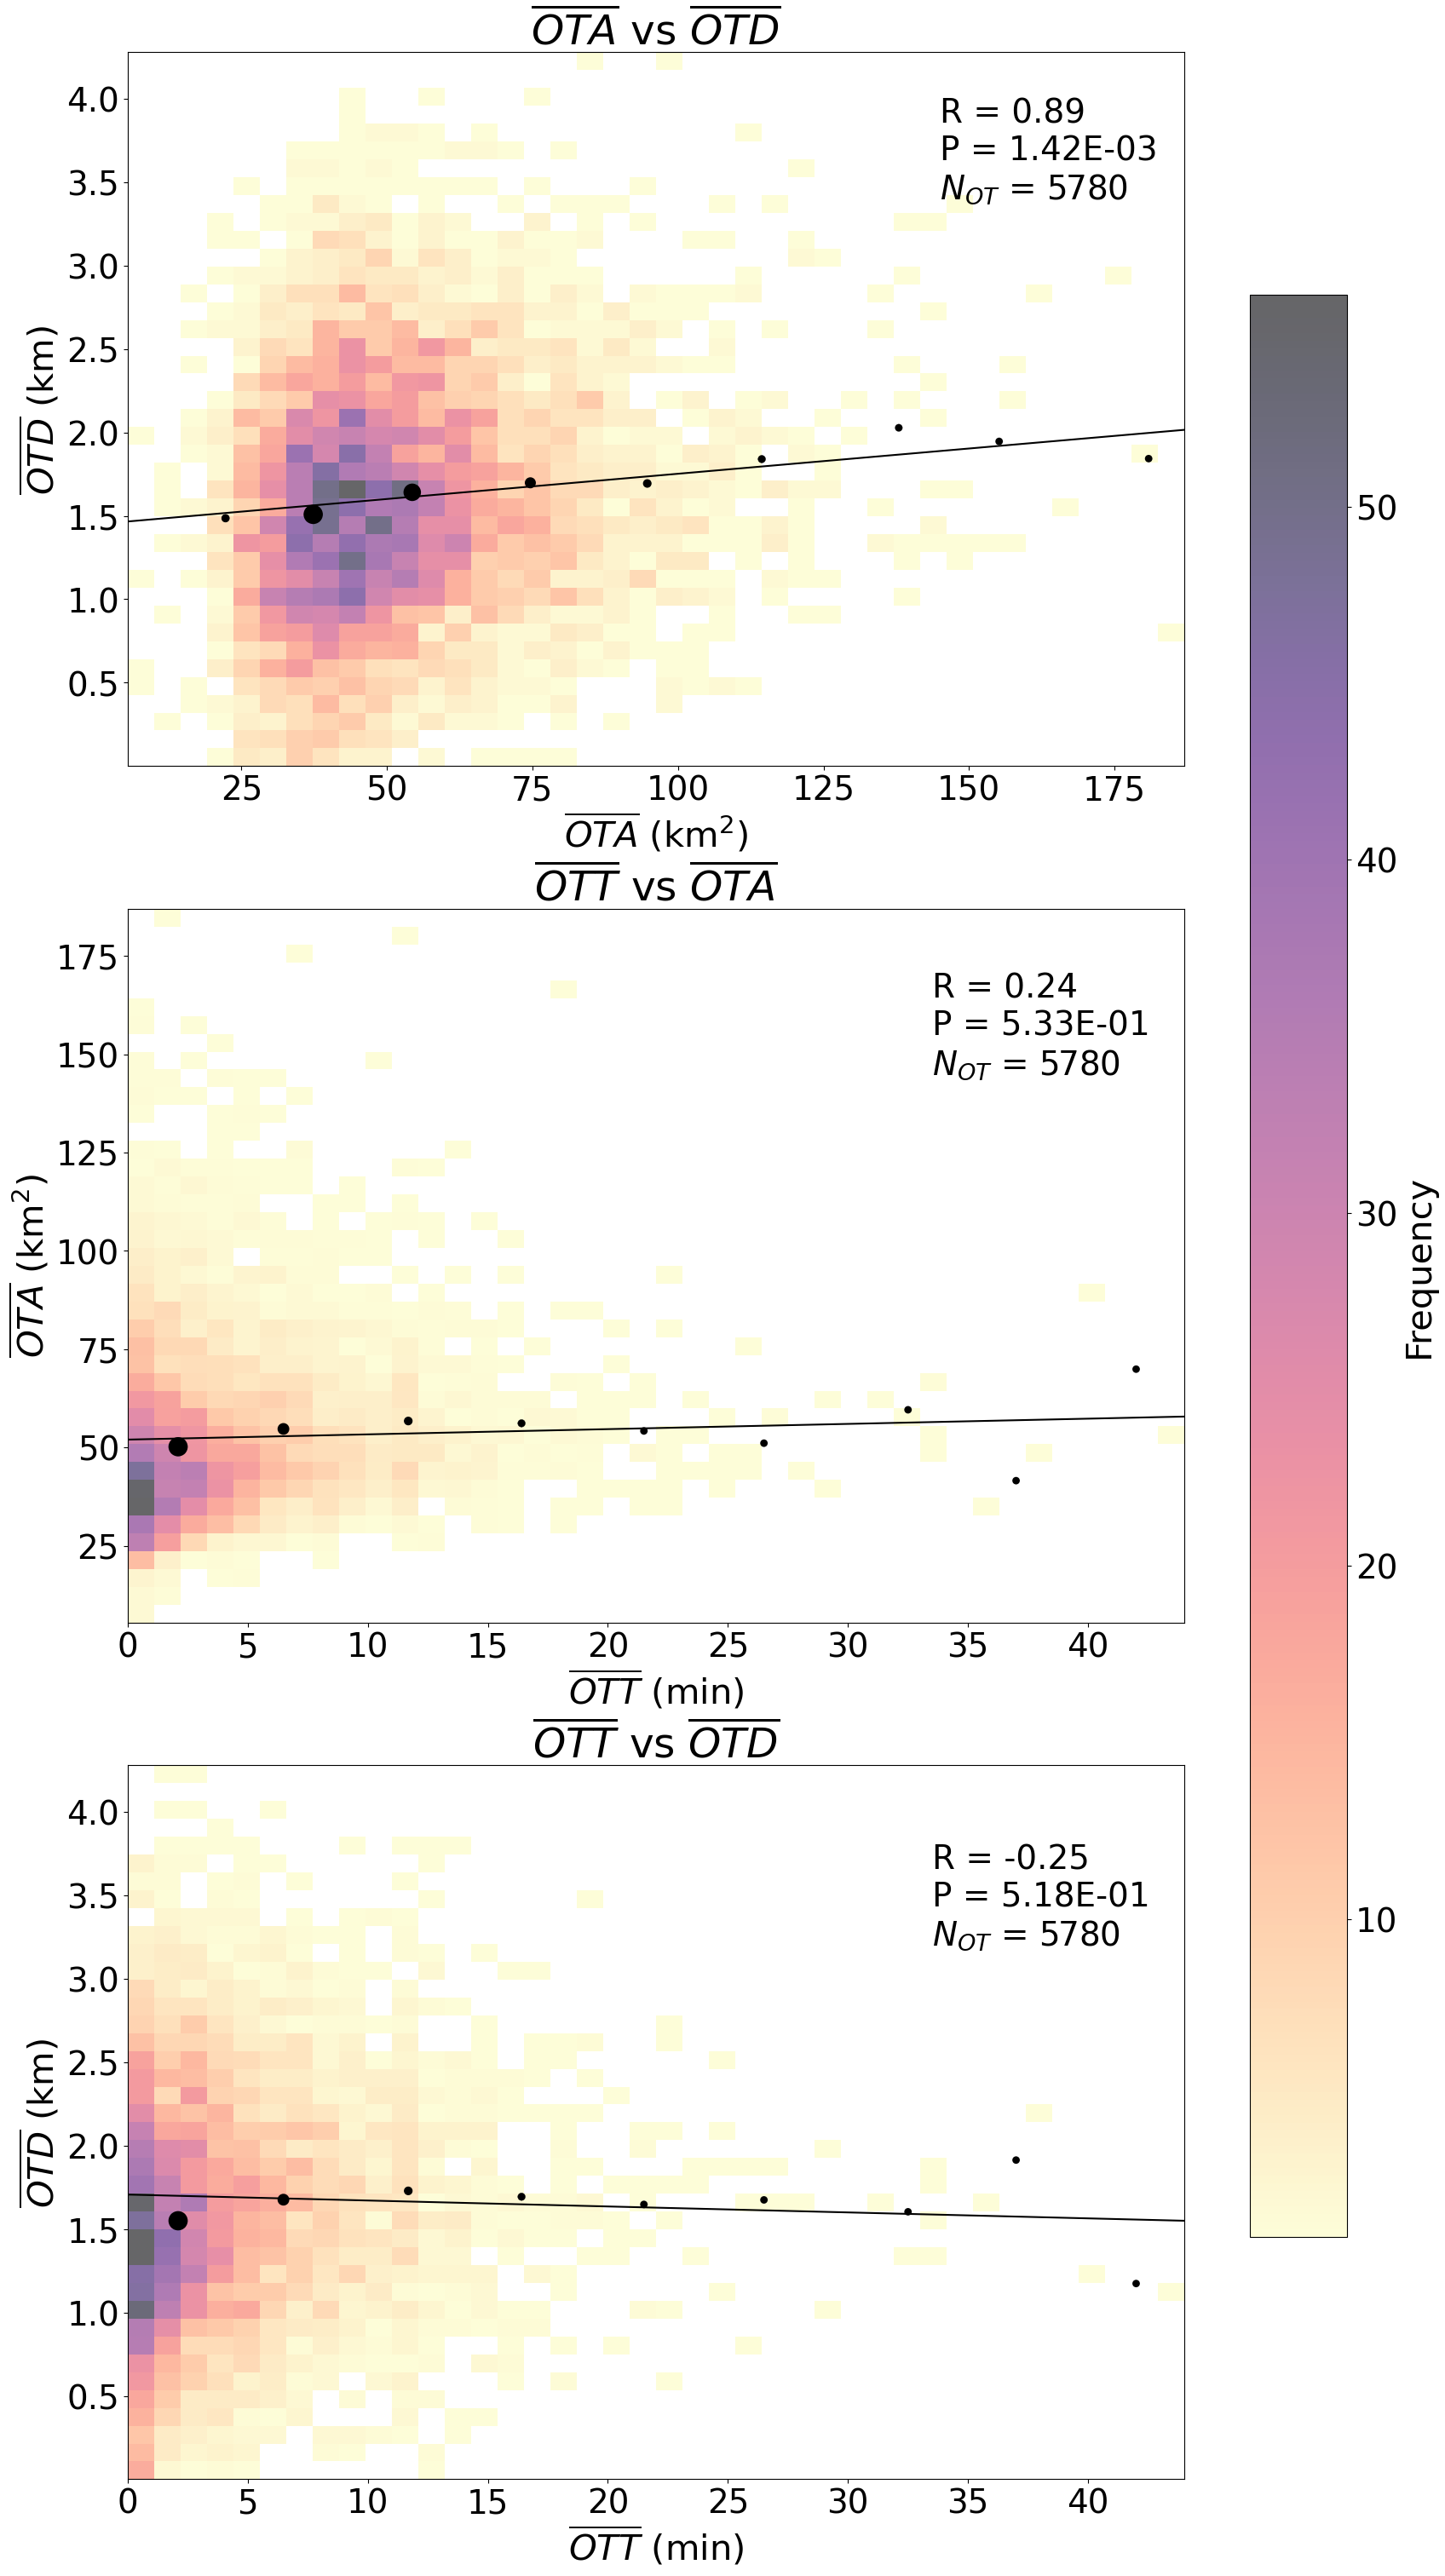

In [55]:
#Plot a scatter plot of the predicted vs actual top of the OT
fig, ax = plt.subplots(3,1,figsize=(20,37))
otd_r_model = scipy.stats.linregress(ota_binned_ota, otd_binned_ota)
r_otd = otd_r_model.rvalue
p_otd = otd_r_model.pvalue
x2 = np.linspace(min(ota_25jan), max(ota_25jan), 100)
y3 = otd_r_model.intercept + x2*otd_r_model.slope
samples = len(ota_25jan)
c,x,y, im1 = ax[0].hist2d(ota_25jan, otd_25jan, bins = (40,40), cmap = rev_map, cmin = 1., cmax = 400., alpha = 0.6)
ax[0].text(145, 3.4, 'R = %0.2f\n'%r_otd + 'P = %0.2E\n'%p_otd + '$N_{OT}$ = %0.0f'%samples, fontsize = 28, color = 'black')
ax[0].plot(x2, y3, '-k')
ax[0].set_title('$\overline{OTA}$ vs $\overline{OTD}$', fontsize = 35)
ax[0].set_xlabel('$\overline{OTA}$ (km$^{2}$)', fontsize= 30)
ax[0].set_ylabel('$\overline{OTD}$ (km)', fontsize = 30)
#plt.legend(loc='best', fontsize = 25)
ax[0].tick_params(axis='x', labelsize=28)
ax[0].tick_params(axis='y', labelsize=28)
#plt.scatter(ota_binned_ota, otd_binned_ota, color = 'black', s = bin_lengths_normed_ota* 1000)
#b = binned_by_ota.boxplot(column = 'otd_25jan', subplots=False, ax = ax)
#bx = b.xaxis
#x_label = bx.get_label()
#bx.set_visible(False)
ax[0].scatter(ota_binned_ota, otd_binned_ota, color = 'black', s = 40, linewidths = bin_lengths_normed_ota*10)

ota_r_model2 = scipy.stats.linregress(duration_binned_duration, ota_binned_duration)
r_ota2 = ota_r_model2.rvalue
p_ota2 = ota_r_model2.pvalue
x5 = np.linspace(min(td_mins), max(td_mins), 100)
y5 = ota_r_model2.intercept + (x5*ota_r_model2.slope)
ax[1].hist2d(td_mins, ota_25jan, bins = (40,40), cmap = rev_map, cmin=1., cmax=400., alpha = 0.6)
ax[1].text(33.5, 145, 'R = %0.2f\n'%r_ota2 + 'P = %0.2E\n'%p_ota2 + '$N_{OT}$ = %0.0f'%samples, fontsize = 28, color = 'black')
ax[1].plot(x5, y5, '-k')
ax[1].set_title('$\overline{OTT}$ vs $\overline{OTA}$', fontsize = 35)
ax[1].set_xlabel('$\overline{OTT}$ (min)', fontsize = 30)
ax[1].set_ylabel('$\overline{OTA}$ (km$^{2}$)', fontsize = 30)
#axes[0,0].legend( loc = 'best', fontsize = 10)
ax[1].tick_params(axis='x', labelsize=28)
ax[1].tick_params(axis='y', labelsize=28)
ax[1].scatter(duration_binned_duration, ota_binned_duration, color = 'black', s = 40, linewidths = bin_lengths_normed_ott*10)

otd_r_model2 = scipy.stats.linregress(duration_binned_duration, otd_binned_duration)
r_otd2 = otd_r_model2.rvalue
p_otd2 = otd_r_model2.pvalue
y6 = otd_r_model2.intercept + (x5*otd_r_model2.slope)
ax[2].hist2d(td_mins, otd_25jan, bins=(40,40), cmap = rev_map, cmin=1., cmax=400., alpha = 0.6)
ax[2].text(33.5, 3.2, 'R = %0.2f\n'%r_otd2 + 'P = %0.2E\n'%p_otd2 + '$N_{OT}$ = %0.0f'%samples, fontsize = 28, color = 'black')
ax[2].set_title('$\overline{OTT}$ vs $\overline{OTD}$', fontsize = 35)
ax[2].plot(x5, y6, '-k')
ax[2].set_xlabel('$\overline{OTT}$ (min)', fontsize = 30)
ax[2].set_ylabel('$\overline{OTD}$ (km)', fontsize = 30)
#axes[0,1].legend(loc = 'best', fontsize = 10)
ax[2].tick_params(axis='x', labelsize=28)
ax[2].tick_params(axis='y', labelsize=28)
ax[2].scatter(duration_binned_duration, otd_binned_duration, color = 'black', s = 40, linewidths = bin_lengths_normed_ott*10)
cbar = fig.colorbar(im1, ax=ax, shrink=0.8)
cbar.set_label('Frequency', fontsize = 30)
cbar.ax.tick_params(labelsize = 28)




In [21]:
bin_lengths_lapse = binned_by_lapse.size()
bin_lengths_normed_lapse = bin_lengths_lapse/max(bin_lengths_lapse)
bin_lengths_n2 = binned_by_n2.size()
bin_lengths_normed_n2 = bin_lengths_n2/max(bin_lengths_n2)

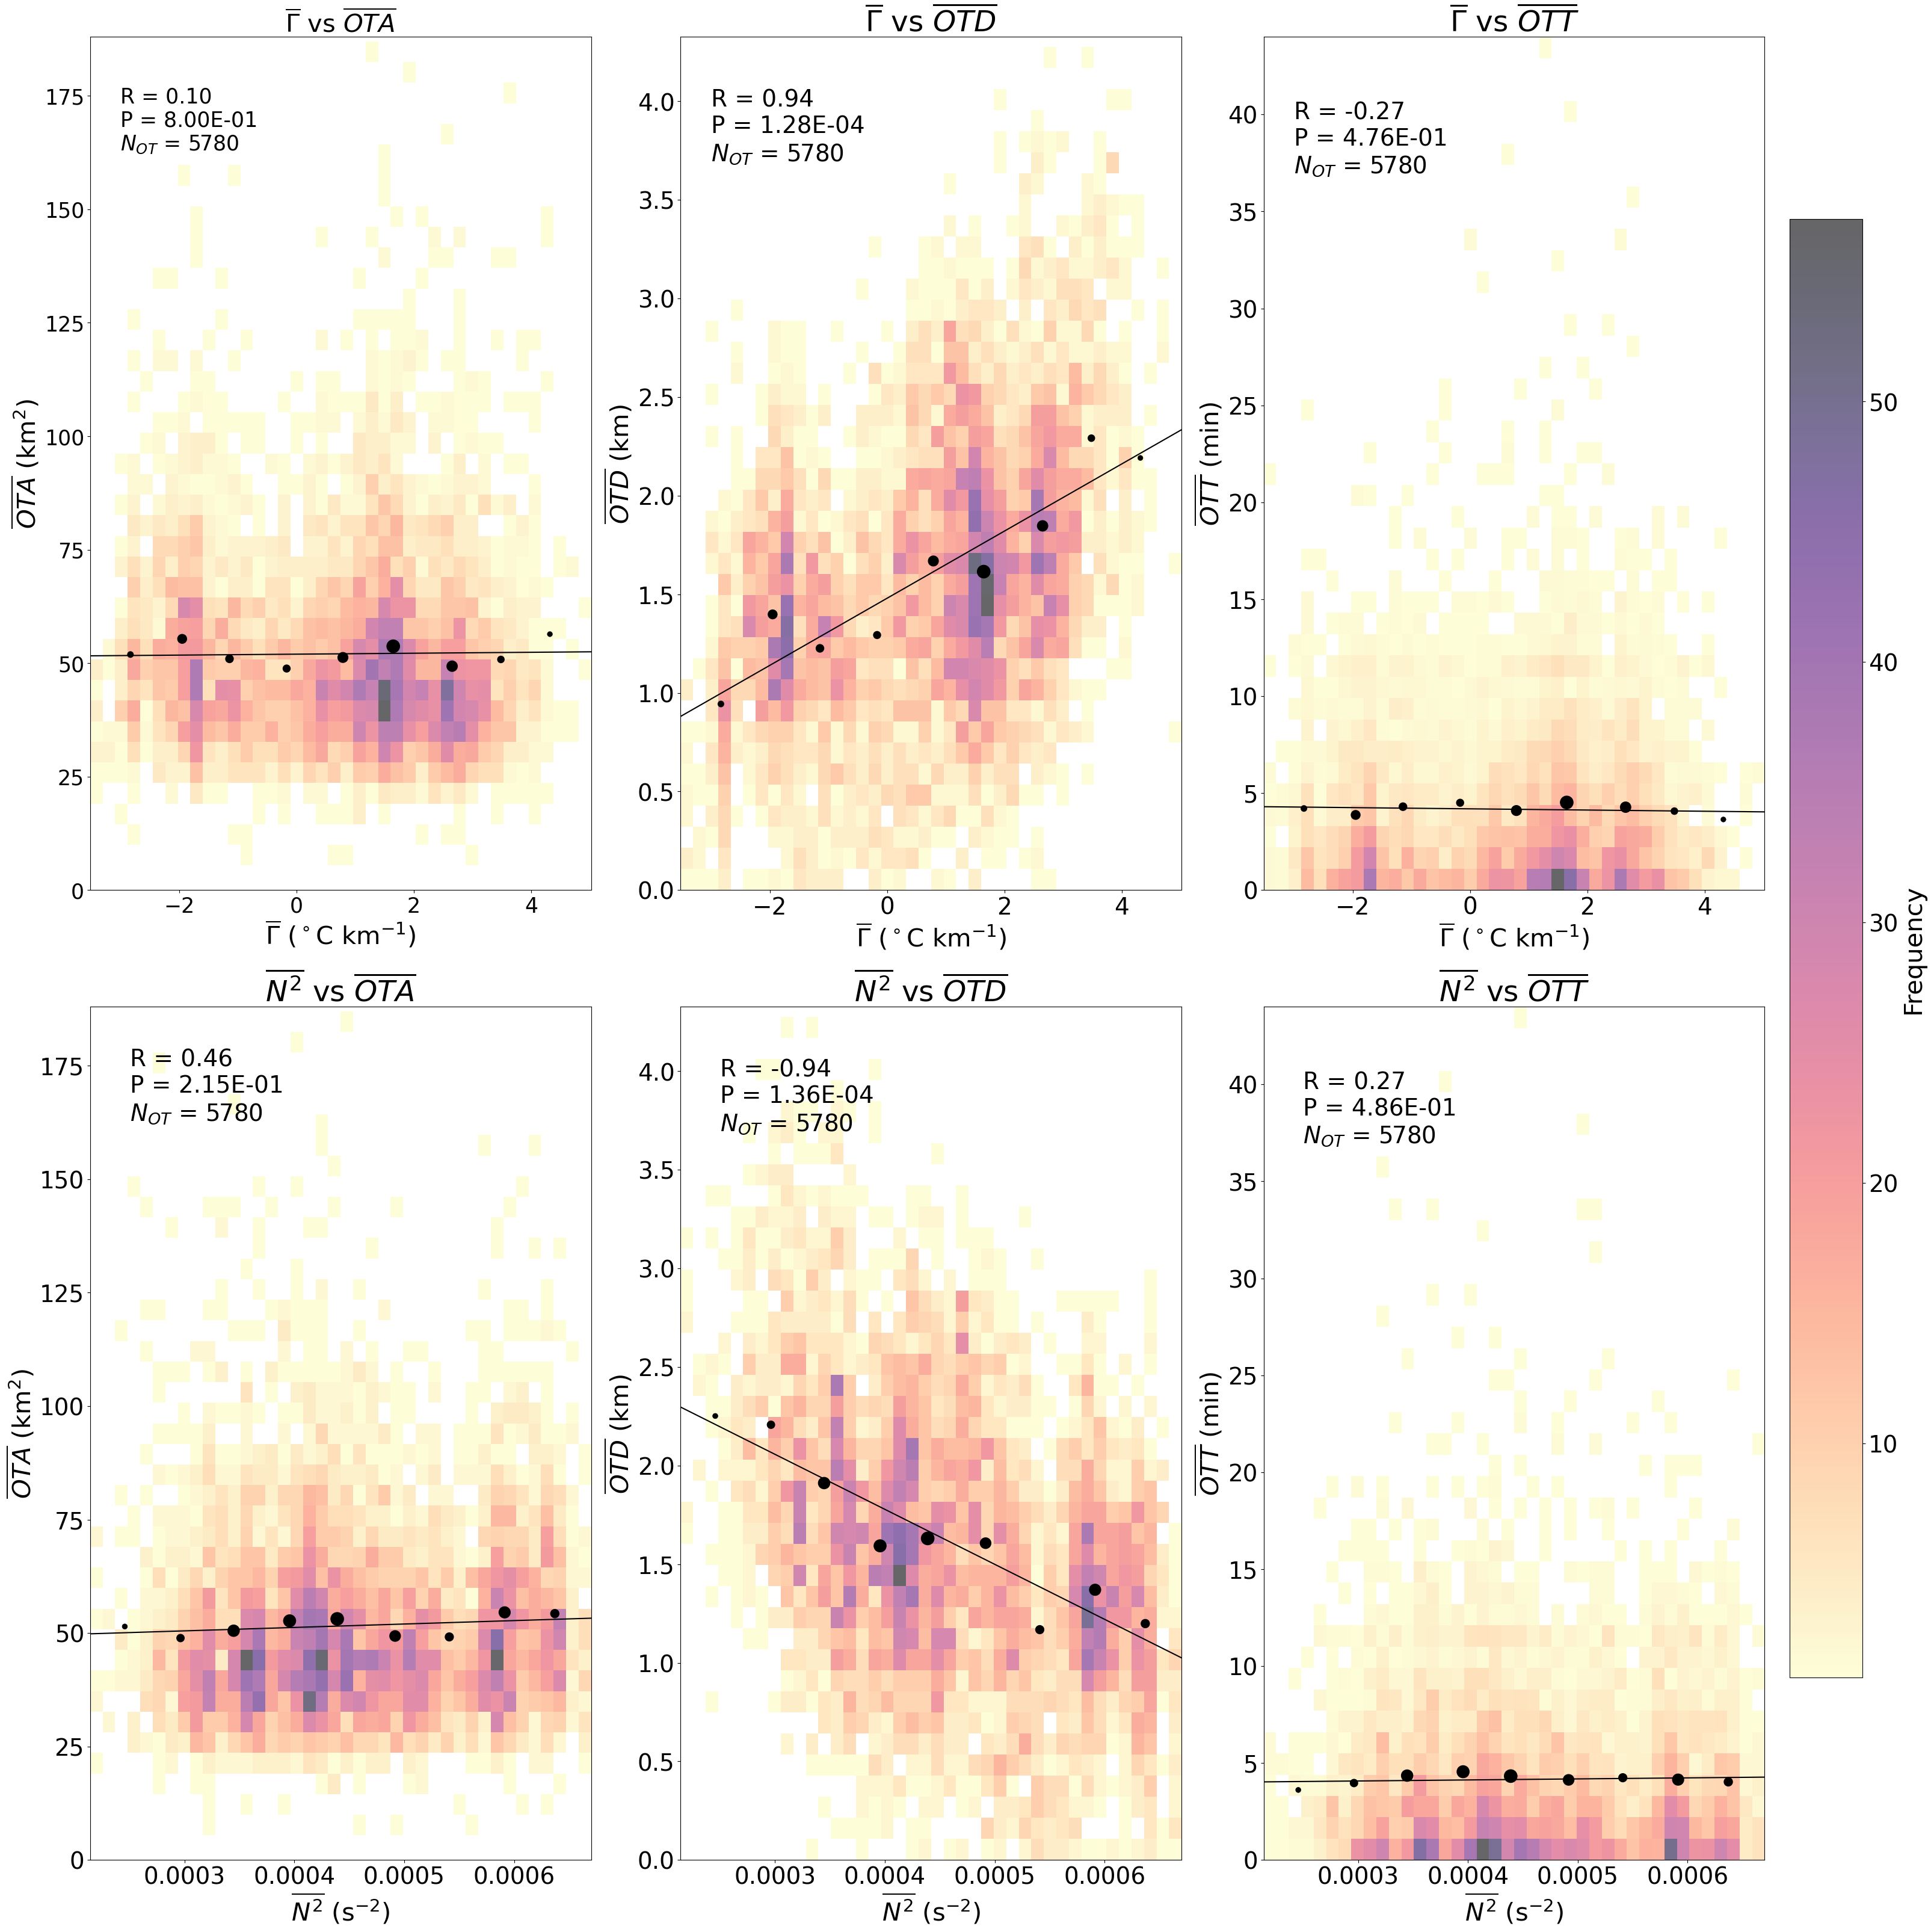

In [42]:
fig1, axes = plt.subplots(2,3,figsize=(32,32), constrained_layout=True)
samples = len(ota_25jan)
ota_r_model = scipy.stats.linregress(lapse_binned_lapse, ota_binned_lapse)
r_ota = ota_r_model.rvalue
p_ota = ota_r_model.pvalue 
x5 = np.linspace(min(jan25_lapserate), max(jan25_lapserate), 100, endpoint=True)
y5 = ota_r_model.intercept + (x5 * ota_r_model.slope)
c,x,y, im1 = axes[0,0].hist2d(jan25_lapserate, ota_25jan, bins = (40,40), cmap = rev_map, cmin=1., cmax= 400., alpha = 0.6)
axes[0,0].text(-3, 163, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
axes[0,0].plot(x5, y5, '-k')
axes[0,0].scatter(lapse_binned_lapse, ota_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
axes[0,0].set_title('$\overline{\Gamma}$ vs $\overline{OTA}$', fontsize = 30)
axes[0,0].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 30)
axes[0,0].set_ylabel('$\overline{OTA}$ (km$^{2}$)', fontsize = 30)
axes[0,0].set_ylim(0, max(ota_25jan)+1)
#axes[0,0].legend( loc = 'best', fontsize = 10)
axes[0,0].tick_params(axis='x', labelsize=25)
axes[0,0].tick_params(axis='y', labelsize=25)

otd_r_model2 = scipy.stats.linregress(lapse_binned_lapse, otd_binned_lapse)
r_otd2 = otd_r_model2.rvalue
p_otd2 = otd_r_model2.pvalue
#print([r_otd, p_otd])
y6 = otd_r_model2.intercept + (x5 * otd_r_model2.slope)
axes[0,1].hist2d(jan25_lapserate, otd_25jan, bins=(40,40), cmap = rev_map, cmin = 1., cmax= 400., alpha = 0.6)
axes[0,1].text(-3, 3.7, 'R = %0.2f\n'%r_otd2 + 'P = %0.2E\n'%p_otd2 + '$N_{OT}$ = %0.0f'%samples, fontsize = 28, color = 'black')
axes[0,1].scatter(lapse_binned_lapse, otd_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
axes[0,1].set_title('$\overline{\Gamma}$ vs $\overline{OTD}$', fontsize = 35)
axes[0,1].plot(x5, y6, '-k')
axes[0,1].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 30)
axes[0,1].set_ylabel('$\overline{OTD}$ (km)', fontsize = 30)
axes[0,1].set_ylim(0, max(otd_25jan)+0.05)
axes[0,1].tick_params(axis='x', labelsize=28)
axes[0,1].tick_params(axis='y', labelsize=28)


ota_r_model3 = scipy.stats.linregress(n2_binned_n2, ota_binned_n2)
r_ota3 = ota_r_model3.rvalue
p_ota3 = ota_r_model3.pvalue
x = np.linspace(min(jan25_n2calc), max(jan25_n2calc), 100, endpoint=True)
y = ota_r_model3.intercept + (x*ota_r_model3.slope)
axes[1,0].hist2d(jan25_n2calc, ota_25jan, bins=(40,40), cmap=rev_map, cmin=1., cmax= 400., alpha = 0.6)
axes[1,0].text(0.00025, 163, 'R = %0.2f\n'%r_ota3 + 'P = %0.2E\n'%p_ota3 + '$N_{OT}$ = %0.0f'%samples, fontsize = 28, color = 'black')
axes[1,0].scatter(n2_binned_n2, ota_binned_n2, color='black', s = 40, linewidths = bin_lengths_normed_n2*10)
axes[1,0].plot(x,y, '-k')
axes[1,0].set_title('$\overline{N^{2}}$ vs $\overline{OTA}$', fontsize = 35)
axes[1,0].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 30)
axes[1,0].set_ylabel('$\overline{OTA}$ (km$^{2}$)', fontsize = 30)
axes[1,0].set_ylim(0, max(ota_25jan)+1)
#axes[1,0].legend( loc = 'best', fontsize = 10)
axes[1,0].tick_params(axis='x', labelsize=28)
axes[1,0].tick_params(axis='y', labelsize=28)

otd_r_model4 = scipy.stats.linregress(n2_binned_n2, otd_binned_n2)
r_otd4 = otd_r_model4.rvalue
p_otd4 = otd_r_model4.pvalue

y7 = otd_r_model4.intercept + (otd_r_model4.slope*x)
axes[1,1].hist2d(jan25_n2calc, otd_25jan, bins=(40,40), cmap = rev_map, cmin=1., cmax= 400., alpha = 0.6)
axes[1,1].text(0.00025, 3.7, 'R = %0.2f\n'%r_otd4 + 'P = %0.2E\n'%p_otd4 + '$N_{OT}$ = %0.0f'%samples, fontsize = 28, color = 'black')
axes[1,1].scatter(n2_binned_n2, otd_binned_n2, color='black', s = 40, linewidths = bin_lengths_normed_n2*10)
axes[1,1].set_title('$\overline{N^{2}}$ vs $\overline{OTD}$', fontsize = 35)
axes[1,1].plot(x,y7, '-k'), 
#axes[1,1].set_xtick(fontsize = 12, angle = 45)
axes[1,1].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 30)
axes[1,1].set_ylabel('$\overline{OTD}$ (km)', fontsize = 30)
axes[1,1].set_ylim(0, max(otd_25jan)+0.05)
#axes[1,1].legend(loc = 'best', fontsize = 20)
axes[1,1].tick_params(axis='x', labelsize=28)
axes[1,1].tick_params(axis='y', labelsize=28)

ota_r_model5 = scipy.stats.linregress(lapse_binned_lapse, duration_binned_lapse)
r_ota5 = ota_r_model5.rvalue
p_ota5 = ota_r_model5.pvalue
y8 = ota_r_model5.intercept + (ota_r_model5.slope*x5)
axes[0,2].hist2d(jan25_lapserate, td_mins, bins = (40,40), cmap = rev_map, cmin=1., cmax= 400., alpha = 0.6)
axes[0,2].text(-3, 37, 'R = %0.2f\n'%r_ota5 + 'P = %0.2E\n'%p_ota5 + '$N_{OT}$ = %0.0f'%samples, fontsize = 28, color = 'black')
axes[0,2].scatter(lapse_binned_lapse, duration_binned_lapse, color='black', s = 40, linewidths = bin_lengths_normed_lapse*10)
axes[0,2].plot(x5, y8, '-k')
axes[0,2].set_title('$\overline{\Gamma}$ vs $\overline{OTT}$', fontsize = 35)
axes[0,2].set_xlabel('$\overline{\Gamma}$ ($^\circ$C km$^{-1}$)', fontsize = 30)
axes[0,2].set_ylabel('$\overline{OTT}$ (min)', fontsize = 30)
axes[0,2].set_ylim(0, max(td_mins))
#axes[0,0].legend( loc = 'best', fontsize = 10)
axes[0,2].tick_params(axis='x', labelsize=28)
axes[0,2].tick_params(axis='y', labelsize=28)

otd_r_model6 = scipy.stats.linregress(n2_binned_n2, duration_binned_n2)
r_otd6 = otd_r_model6.rvalue
p_otd6 = otd_r_model6.pvalue
#print([r_otd, p_otd])
y9 = otd_r_model6.intercept + (x*otd_r_model6.slope)
axes[1,2].hist2d(jan25_n2calc, td_mins, bins=(40,40), cmap = rev_map, cmin=1., cmax= 400., alpha = 0.6)
axes[1,2].text(0.00025, 37, 'R = %0.2f\n'%r_otd6 + 'P = %0.2E\n'%p_otd6 + '$N_{OT}$ = %0.0f'%samples, fontsize = 28, color = 'black')
axes[1,2].scatter(n2_binned_n2, duration_binned_n2, color='black', s = 40, linewidths = bin_lengths_normed_n2*10)
axes[1,2].set_title('$\overline{N^{2}}$ vs $\overline{OTT}$', fontsize = 35)
axes[1,2].plot(x, y9, '-k')
axes[1,2].set_xlabel('$\overline{N^{2}}$ (s$^{-2}$)', fontsize = 30)
axes[1,2].set_ylabel('$\overline{OTT}$ (min)', fontsize = 30)
axes[1,2].set_ylim(0, max(td_mins))
#axes[0,1].legend(loc = 'best', fontsize = 10)
axes[1,2].tick_params(axis='x', labelsize=28)
axes[1,2].tick_params(axis='y', labelsize=28)
cbar = fig1.colorbar(im1, ax=axes[:, 2], shrink=0.8)
cbar.set_label('Frequency', fontsize = 30)
cbar.ax.tick_params(labelsize = 28)
#plt.suptitle('Mean Statistics', fontsize = 35)
#plt.savefig('./four_panel_mean_07.png')

In [43]:
#Create the OTA bins
bins_cape = np.linspace(min(mucape), max(mucape), 10)
label_cape = bins_cape[:-1]
labels_cape = list(map(str, label_cape))
filtered_df['cape_bins'] = pd.cut(filtered_df.mucape, bins = bins_cape, labels = labels_cape, right=True, include_lowest=True)

In [44]:
binned_by_cape = filtered_df.groupby('cape_bins')
mean_cape_binned = binned_by_cape.mean('mucape').mucape
mean_ota_cape = binned_by_cape.mean('mucape').ota_25jan
mean_otd_cape = binned_by_cape.mean('mucape').otd_25jan
mean_ott_cape = binned_by_cape.mean('mucape').duration

bin_lengths_cape = binned_by_cape.size()
bin_lengths_normed_cape = bin_lengths_cape/max(bin_lengths_cape)

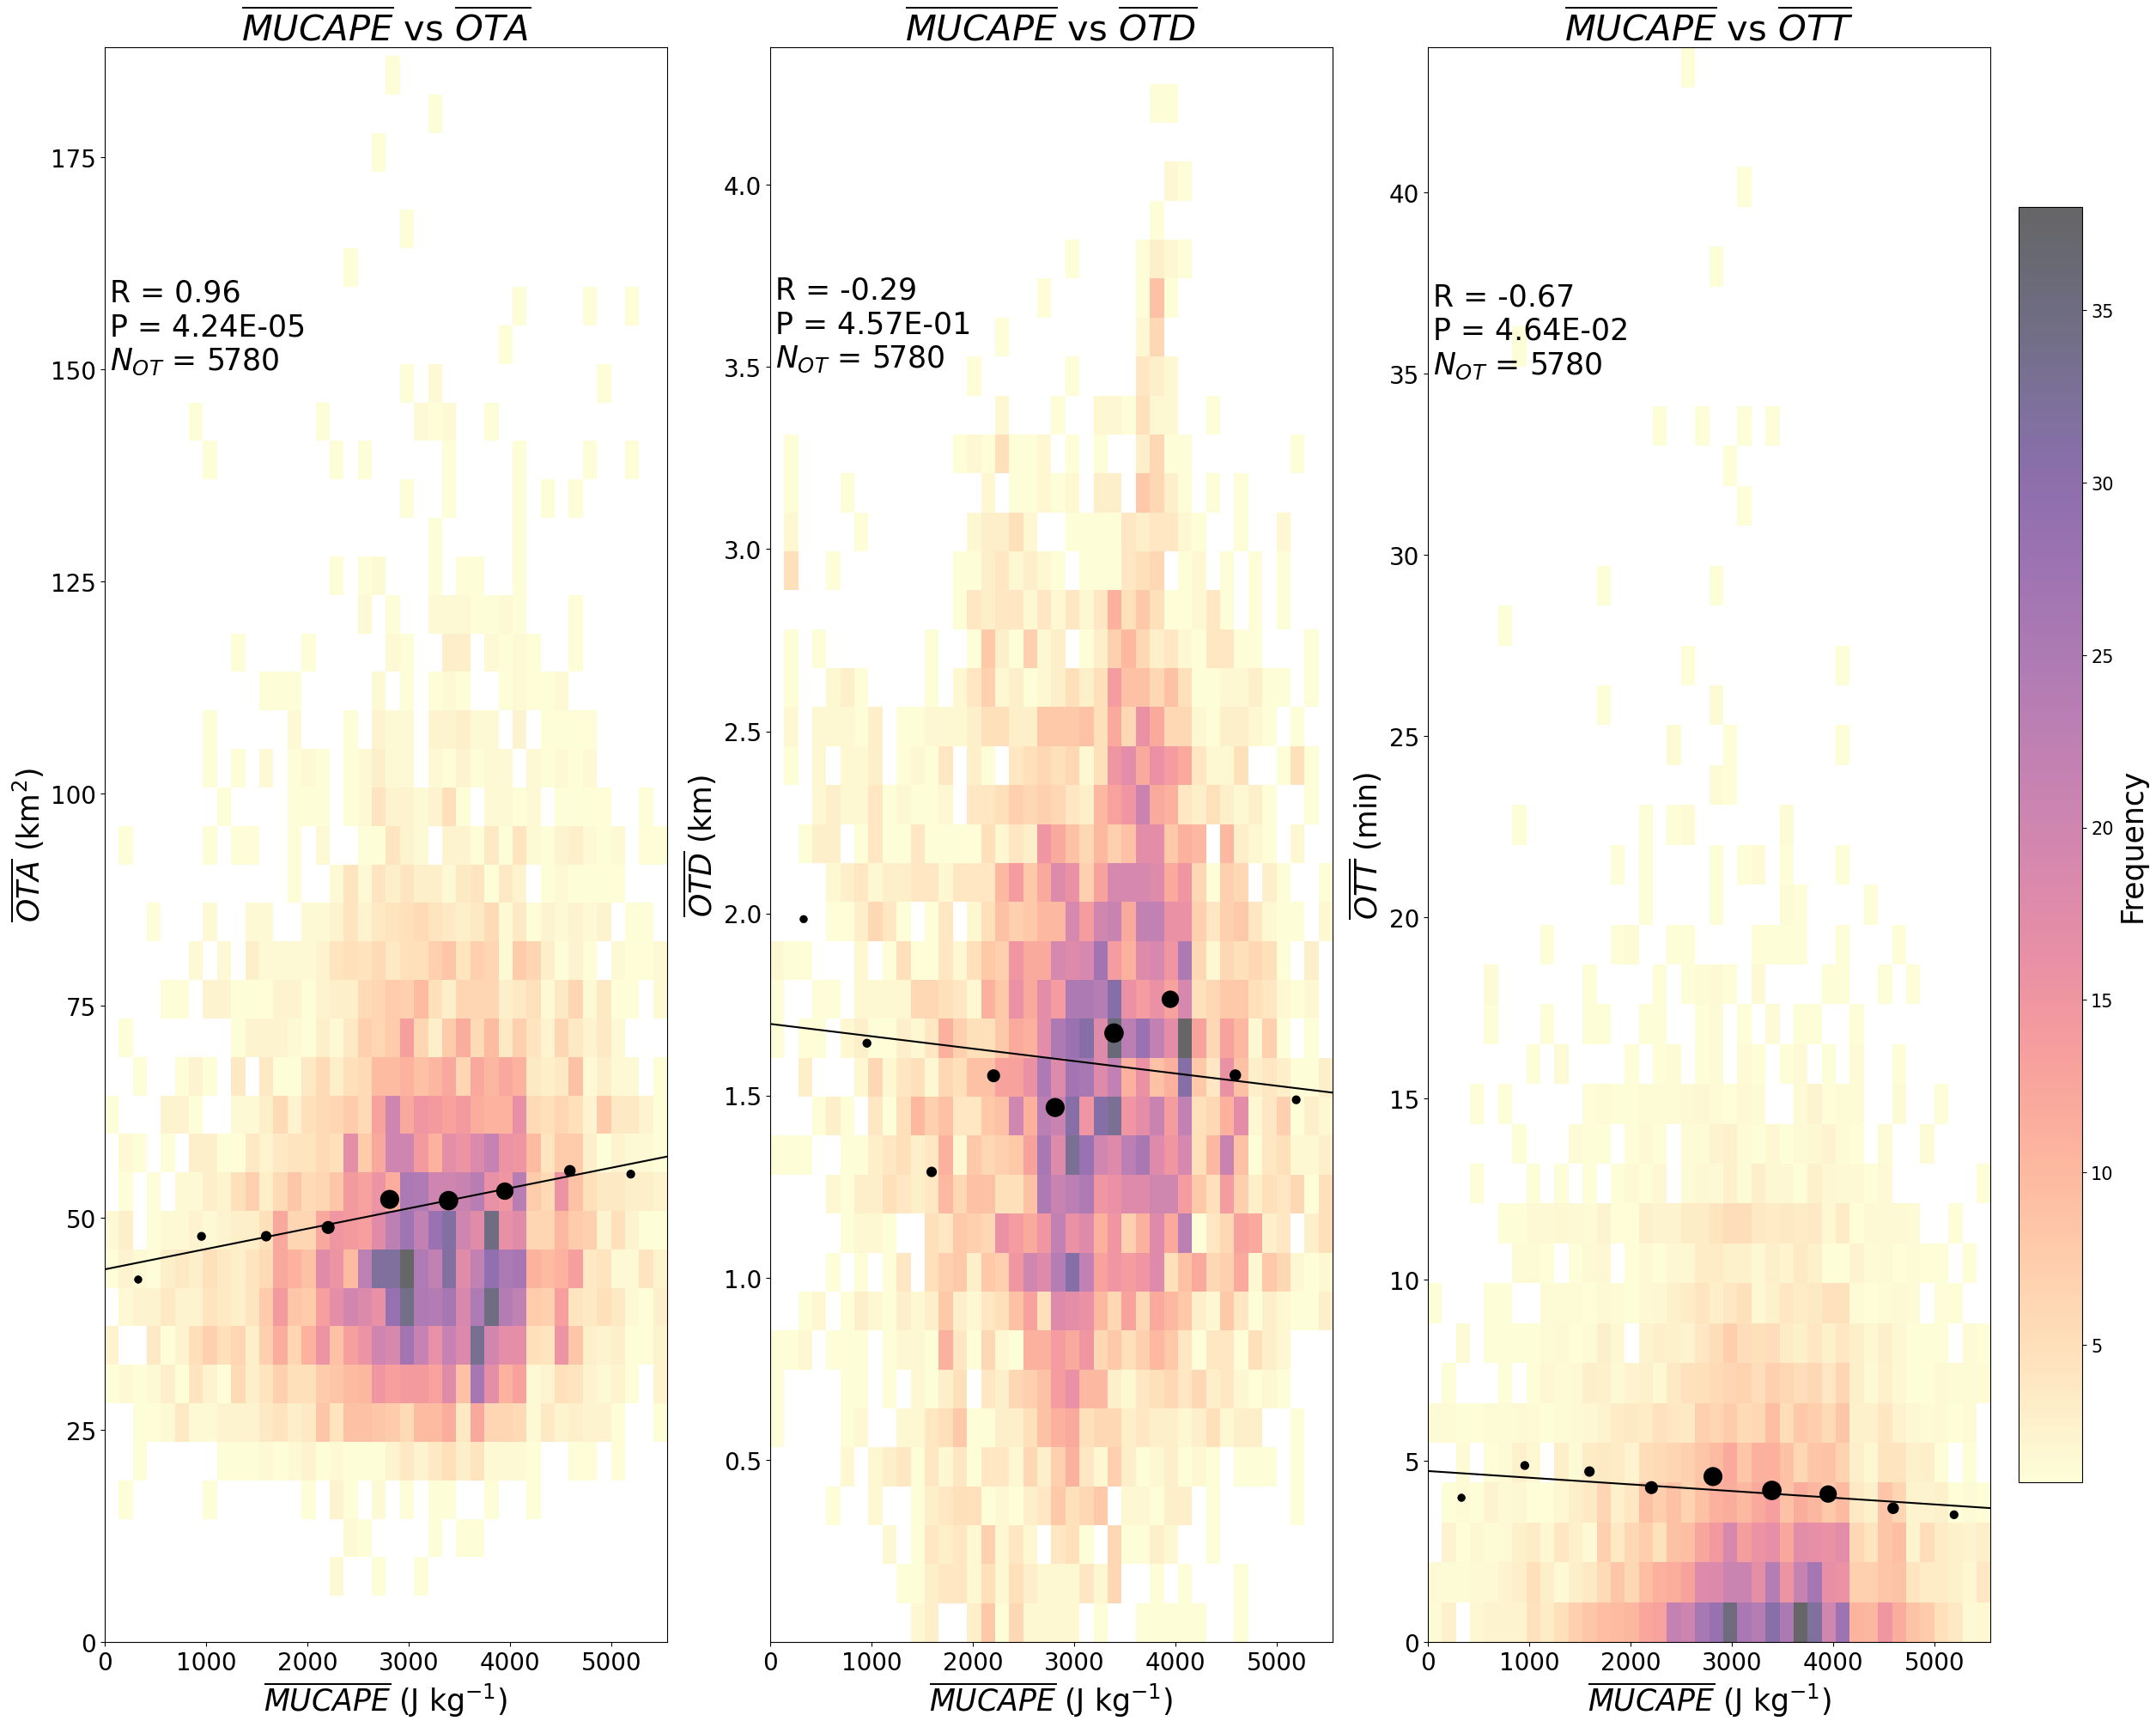

In [46]:
#Plot OTA and OTD as a function of CAPE
fig1, axes = plt.subplots(1,3,figsize=(25, 20), constrained_layout=True)
samples = len(ota_25jan)

ota_r_model = scipy.stats.linregress(mean_cape_binned, mean_ota_cape)
r_ota = ota_r_model.rvalue
p_ota = ota_r_model.pvalue
x2 = np.linspace(min(mucape), max(mucape),100)
y2 = ota_r_model.intercept + x2*ota_r_model.slope
#print([r_ota, p_ota])

c,x,y, im1 = axes[0].hist2d(mucape, ota_25jan, bins = (40,40), cmap = rev_map, cmin=1., cmax=400., alpha = 0.6)
axes[0].text(50, 150, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
axes[0].scatter(mean_cape_binned, mean_ota_cape, color='black',  s = 40, linewidths = bin_lengths_normed_cape*10)
#axes[0].scatter(mean_cape_binned, mean_ota_cape, color = 'black', s = bin_lengths_normed_cape* 1000)
axes[0].plot(x2, y2, '-k')
axes[0].set_title('$\overline{MUCAPE}$ vs $\overline{OTA}$', fontsize = 30)
axes[0].set_xlabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 25)
axes[0].set_ylabel('$\overline{OTA}$ (km$^{2}$)', fontsize = 25)
axes[0].set_ylim(0, max(ota_25jan)+1)
#axes[0].legend( loc = 'best', fontsize = 10)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)

otd_r_model = scipy.stats.linregress(mean_cape_binned, mean_otd_cape)
r_otd = otd_r_model.rvalue
p_otd = otd_r_model.pvalue
y3 = otd_r_model.intercept + x2*otd_r_model.slope
#print([r_otd, p_otd])
c,x,y, im1 = axes[1].hist2d(mucape, otd_25jan, bins = (40,40), cmap = rev_map, cmin=1., cmax=400., alpha = 0.6)
axes[1].text(50, 3.5, 'R = %0.2f\n'%r_otd + 'P = %0.2E\n'%p_otd + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
axes[1].scatter(mean_cape_binned, mean_otd_cape, color='black', s = 40, linewidths = bin_lengths_normed_cape*10)
#axes[1].scatter(mean_cape_binned, mean_otd_cape, color = 'black', s = bin_lengths_normed_cape*1000)
axes[1].set_title('$\overline{MUCAPE}$ vs $\overline{OTD}$', fontsize = 30)
axes[1].plot(x2, y3, '-k')
axes[1].set_xlabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 25)
axes[1].set_ylabel('$\overline{OTD}$ (km)', fontsize = 25)
axes[1].set_ylim(min(otd_25jan), max(otd_25jan)+0.1)
#axes[1].legend(loc = 'best', fontsize = 20)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
cbar = fig1.colorbar(im1, ax=axes[2], shrink=0.8)
cbar.set_label('Frequency', fontsize = 25)
cbar.ax.tick_params(labelsize = 15)
#plt.suptitle('Mean Statistics', fontsize = 35)
#plt.savefig('./mucape_mean_07.png')

otd_r_model2 = scipy.stats.linregress(mean_cape_binned, mean_ott_cape)
r_otd2 = otd_r_model2.rvalue
p_otd2 = otd_r_model2.pvalue
y4 = otd_r_model2.intercept + x2*otd_r_model2.slope
#print([r_otd, p_otd])
c,x,y, im1 = axes[2].hist2d(mucape, td_mins, bins = (40,40), cmap = rev_map, cmin=1., cmax=400., alpha = 0.6)
axes[2].text(50, 35, 'R = %0.2f\n'%r_otd2 + 'P = %0.2E\n'%p_otd2 + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
axes[2].scatter(mean_cape_binned, mean_ott_cape, color='black', s = 40, linewidths = bin_lengths_normed_cape*10)
#axes[1].scatter(mean_cape_binned, mean_otd_cape, color = 'black', s = bin_lengths_normed_cape*1000)
axes[2].set_title('$\overline{MUCAPE}$ vs $\overline{OTT}$', fontsize = 30)
axes[2].plot(x2, y4, '-k')
axes[2].set_xlabel('$\overline{MUCAPE}$ (J kg$^{-1}$)', fontsize = 25)
axes[2].set_ylabel('$\overline{OTT}$ (min)', fontsize = 25)
axes[2].set_ylim(0, max(td_mins))
#axes[1].legend(loc = 'best', fontsize = 20)
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
#plt.savefig('./mucape_mean_07.png')

In [41]:
mean_area = grouped_ots.mean("area_polygon")
mean_depth = grouped_ots.mean("ot_depth")

In [42]:
mam = np.mean(mean_area['area_polygon'].values)
mdm = np.mean(mean_depth['dz_lowest_6'].values)

mam, mdm


(51.858723176195674, 1.594692956655612)

In [43]:
mean_area['hour'] = mean_area['hour'].astype(int)
mean_depth['hour'] = mean_depth['hour'].astype(int)

In [44]:
nov_stats = gpd_jan25[gpd_jan25.month == 11]
dec_stats = gpd_jan25[gpd_jan25.month == 12]
jan_stats = gpd_jan25[gpd_jan25.month == 1] 
feb_stats = gpd_jan25[gpd_jan25.month == 2]
grouped_nov = nov_stats.groupby('cell')
grouped_dec = dec_stats.groupby('cell')
grouped_jan = jan_stats.groupby('cell')
grouped_feb = feb_stats.groupby('cell')

In [45]:
nov_area = grouped_nov.mean("area_polygon").area_polygon
nov_depth = grouped_nov.mean("dz_lowest_6").dz_lowest_6
meana_nov = np.mean(nov_area)
meand_nov = np.mean(nov_depth)

dec_area = grouped_dec.mean("area_polygon").area_polygon
dec_depth = grouped_dec.mean("dz_lowest_6").dz_lowest_6
meana_dec = np.mean(dec_area)
meand_dec = np.mean(dec_depth)

jan_area = grouped_jan.mean("area_polygon").area_polygon
jan_depth = grouped_jan.mean("dz_lowest_6").dz_lowest_6
meana_jan = np.mean(jan_area)
meand_jan = np.mean(jan_depth)

feb_area = grouped_feb.mean("area_polygon").area_polygon
feb_depth = grouped_feb.mean("dz_lowest_6").dz_lowest_6
meana_feb = np.mean(feb_area)
meand_feb = np.mean(feb_depth)

print(meana_nov, meana_dec, meana_jan, meana_feb)

49.666910295030945 51.78975043343659 52.96523993042427 53.6422420723597


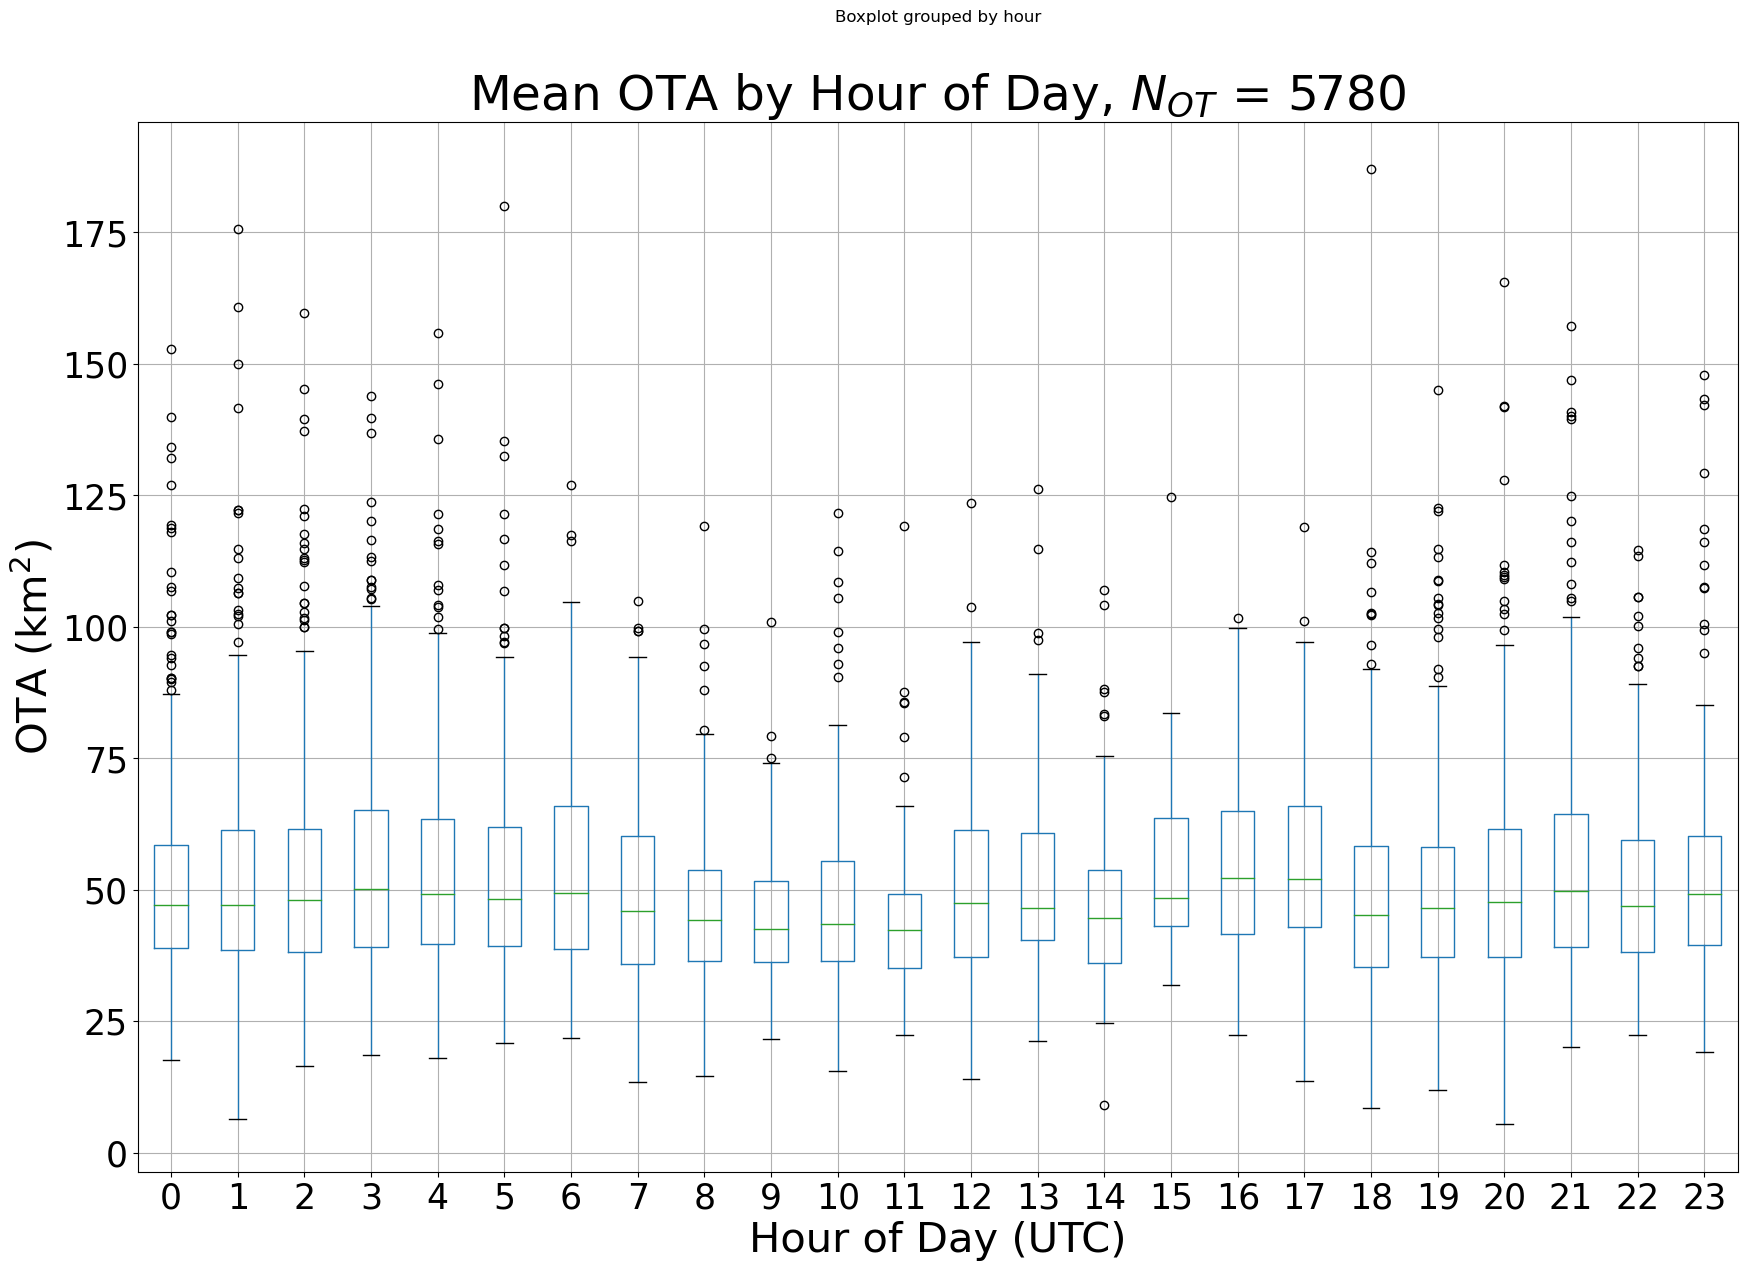

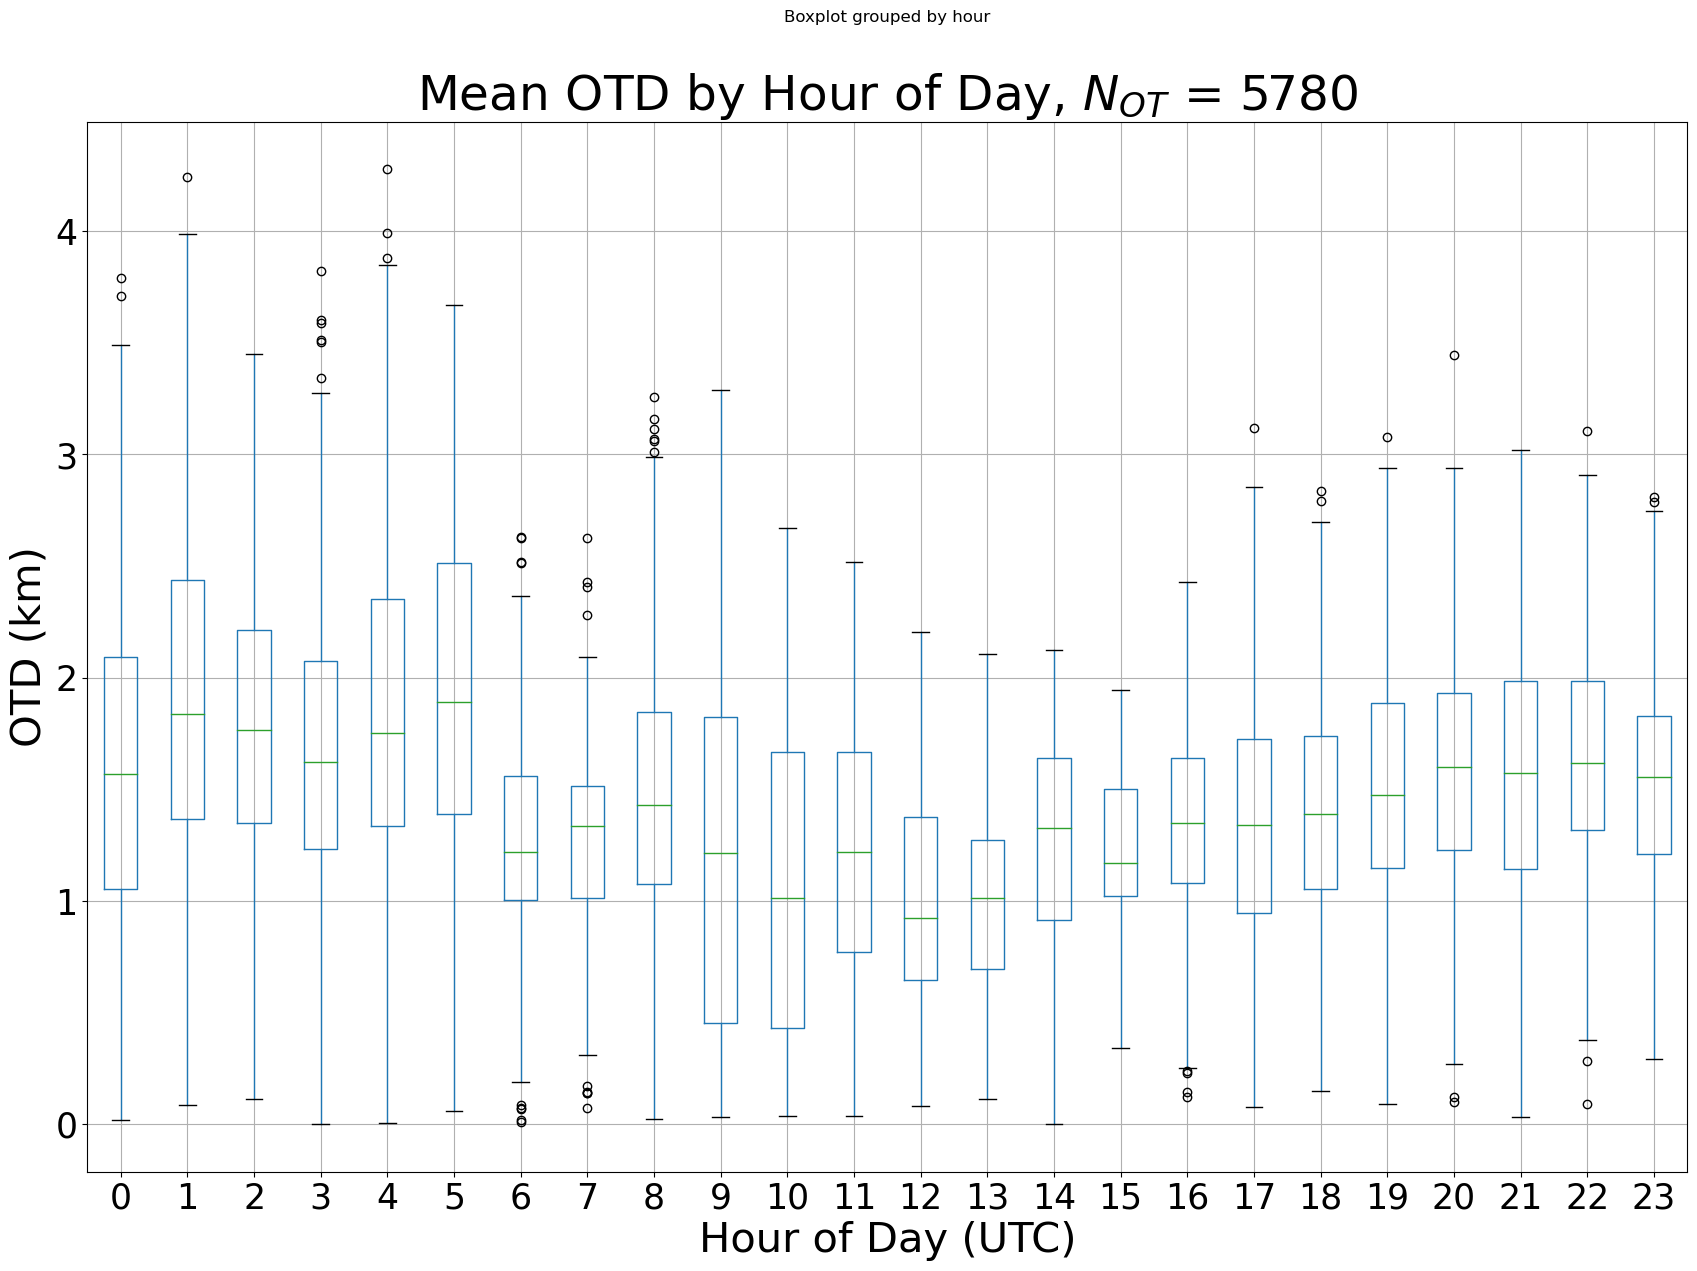

In [46]:
bpa = mean_area.boxplot(column='area_polygon', by='hour', figsize = (20, 14))
bpa.set_ylabel('OTA (km$^{2}$)', fontsize = 30)
bpa.set_xlabel('Hour of Day (UTC)', fontsize = 30)
bpa.tick_params(axis='x', labelsize=25)
bpa.tick_params(axis='y', labelsize = 25)
bpa.set_title('Mean OTA by Hour of Day, $N_{OT}$ = %0.0f'%samples, fontsize = 35)
bpd = mean_depth.boxplot(column='dz_lowest_6', by = 'hour', figsize = (20, 14))
bpd.set_ylabel('OTD (km)', fontsize = 30)
bpd.set_xlabel('Hour of Day (UTC)', fontsize = 30)
bpd.set_title('Mean OTD by Hour of Day, $N_{OT}$ = %0.0f'%samples, fontsize = 35)
bpd.tick_params(axis='x', labelsize=25)
bpd.tick_params(axis='y', labelsize = 25)



Text(0.5, 1.0, 'All OT Tracks, N = 5780')

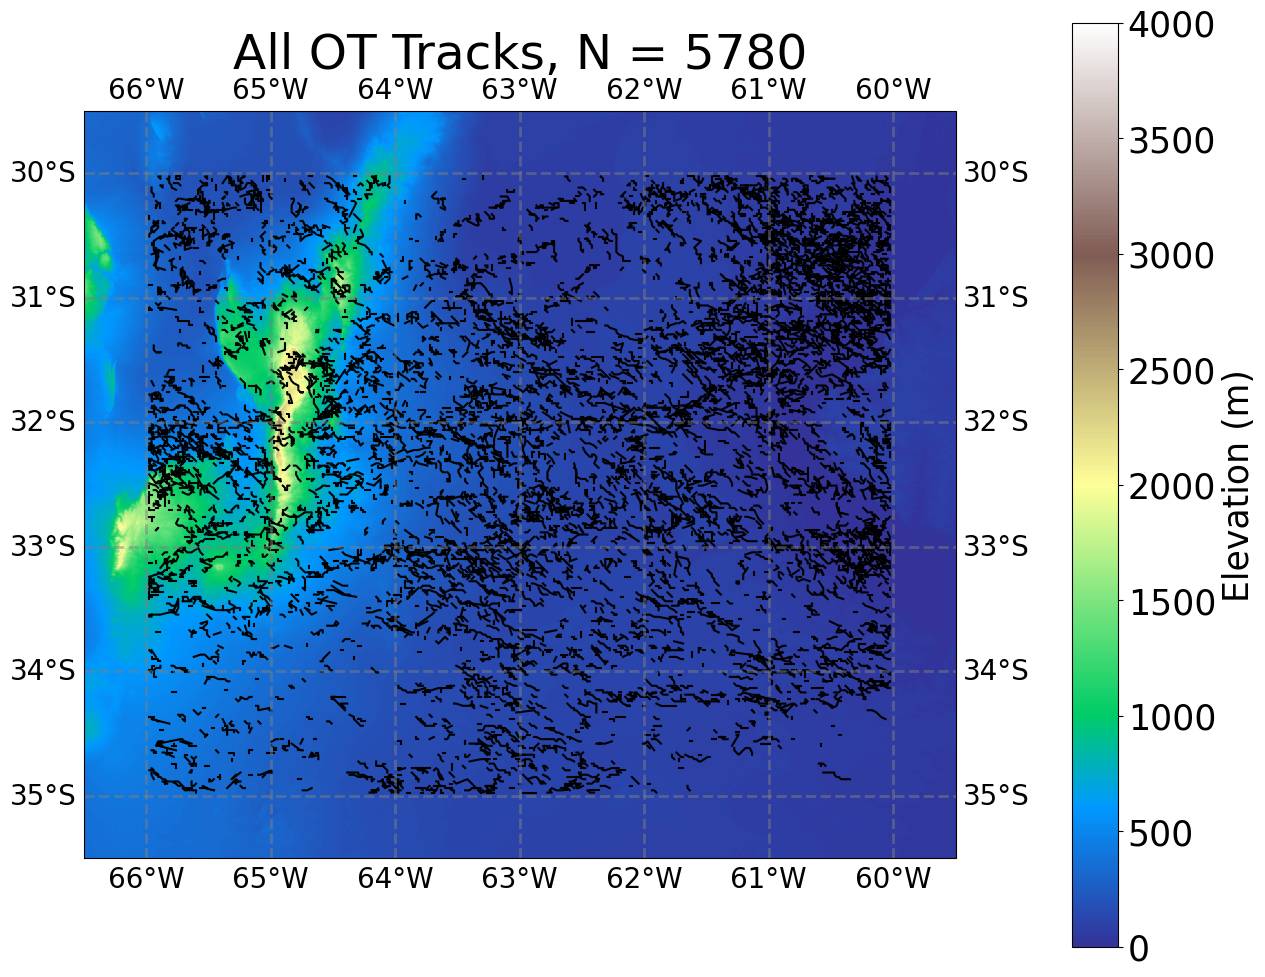

In [36]:
llcrnr=[-35.5, -66.5]
urcrnr=[-29.5, -59.5]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size':20}
gl.ylabel_style = {'size':20}
cb1 = plt.colorbar(cm,shrink=0.8, pad=0.1)
cb1.set_label('Elevation (m)', fontsize = 25)
for name, group in grouped_ots:
    tracks = grouped_ots.get_group(name)
    plt.plot(tracks.lon, tracks.lat, color = 'k')
cb1.ax.tick_params(labelsize = 25)
plt.title('All OT Tracks, N = %0.0f'%samples, fontsize = 35)

In [20]:
max_lats = grouped_ots.max('area_polygon').lat
max_lons = grouped_ots.max('area_polygon').lon
max_lons_depth = grouped_ots.max('dz_lowest_6').lon
max_lats_depth = grouped_ots.max('dz_lowest_6').lat
max_area = grouped_ots.max('area_polygon').area_polygon
max_depth = grouped_ots.max('dz_lowest_6').dz_lowest_6
duration = grouped_ots.duration.nth(0)

Text(0.5, 1.0, 'Max OTA, N = 5780')

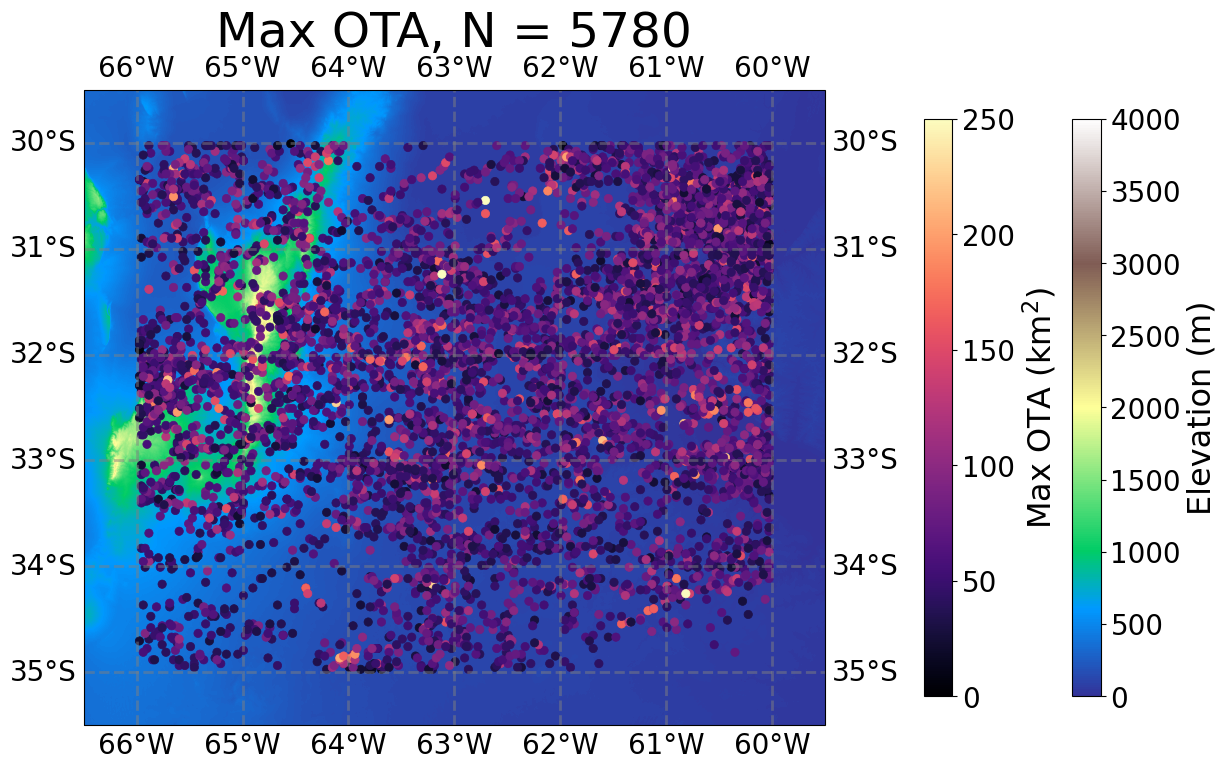

In [47]:
import cartopy.crs as ccrs
llcrnr=[-35.5, -66.5]
urcrnr=[-29.5, -59.5]
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]] 
ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size':20}
gl.ylabel_style = {'size':20}

cm2 = plt.scatter(max_lons, max_lats,c=max_area,vmin=0.,vmax=250.,
                     facecolors='none',cmap='magma',linewidth=0.5)

cb1 = plt.colorbar(cm, shrink=0.5, pad=0.0)
cb1.set_label('Elevation (m)', fontsize = 23)
cb1.ax.tick_params(labelsize = 20)
cb2 = plt.colorbar(cm2, shrink=0.5, pad=0.1)
cb2.set_label('Max OTA (km$^{2}$)', fontsize = 23)
cb2.ax.tick_params(labelsize = 20)

ax_map.set_title('Max OTA, N = %0.0f'%samples, fontsize = 35)

Text(0.5, 1.0, 'Max OTD, N = 5780')

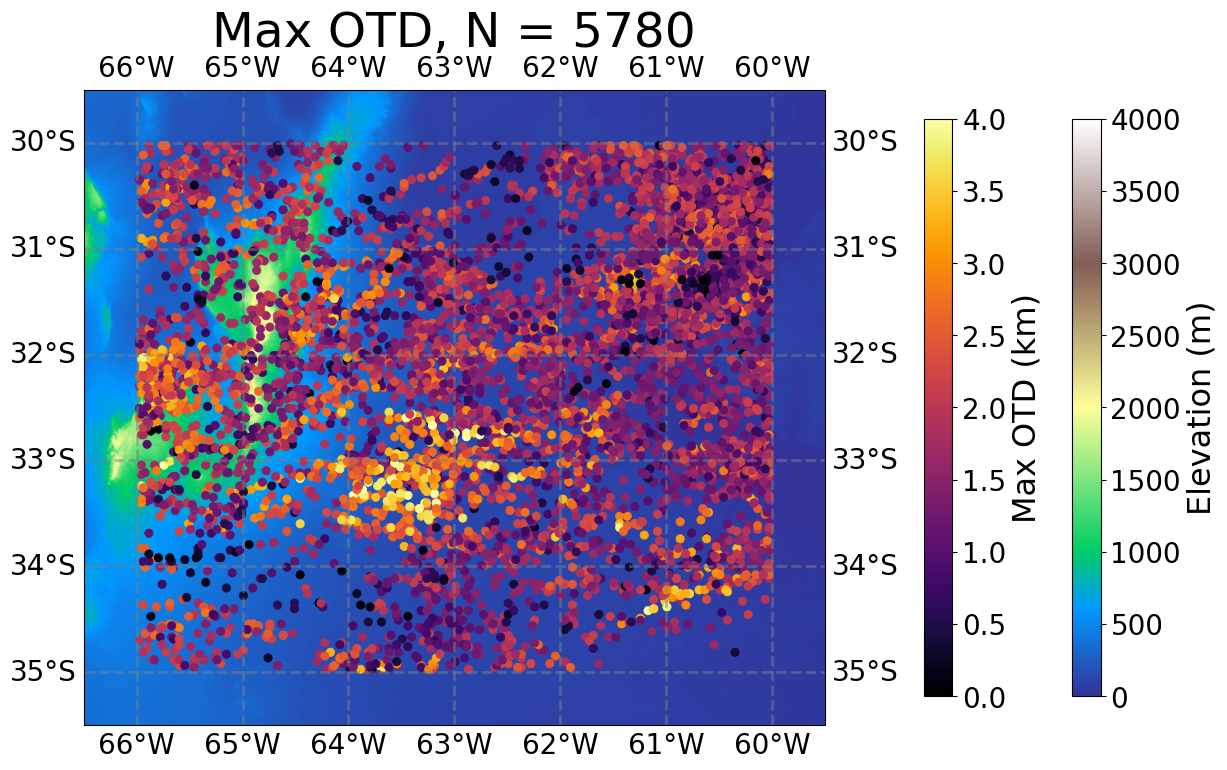

In [23]:
llcrnr=[-35.5, -66.5]
urcrnr=[-29.5, -59.5]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size':20}
gl.ylabel_style = {'size':20}

cm2 = plt.scatter(max_lons_depth, max_lats_depth,c=max_depth, vmin=0.,vmax=4.,
                     facecolors='none',cmap='inferno',linewidth=0.5)

cb1 = plt.colorbar(cm, shrink=0.5, pad=0.0)
cb1.set_label('Elevation (m)', fontsize = 23)
cb1.ax.tick_params(labelsize = 20)
cb2 = plt.colorbar(cm2, shrink=0.5, pad=0.1)
cb2.set_label('Max OTD (km)', fontsize = 23)
cb2.ax.tick_params(labelsize = 20)



ax_map.set_title('Max OTD, N = %0.0f'%samples, fontsize = 35)

In [24]:
files_count = {}

In [80]:
import glob
datestr='20190211'
for hr in np.arange(0,24,1):
        if hr <=9:
                files = sorted(glob.glob(f'/data/accp/a/snesbitt/arm/goesV2/*{datestr}.0{hr}????.cdf'))
                files_count[hr] =  files_count[hr] +  len(files)
        else:
                files = sorted(glob.glob(f'/data/accp/a/snesbitt/arm/goesV2/*{datestr}.{hr}????.cdf')) 
                files_count[hr] =  files_count[hr] + len(files)

In [81]:
file_df = pd.DataFrame(data=files_count, index = np.arange(0,24,1))

files_hourly = file_df.iloc[0]

In [82]:
counts_per_hour = gpd_jan25['hours'].value_counts()
sum_cph = sum(counts_per_hour)
files_normed = counts_per_hour/files_hourly
hrs = np.arange(0, 24, 1)

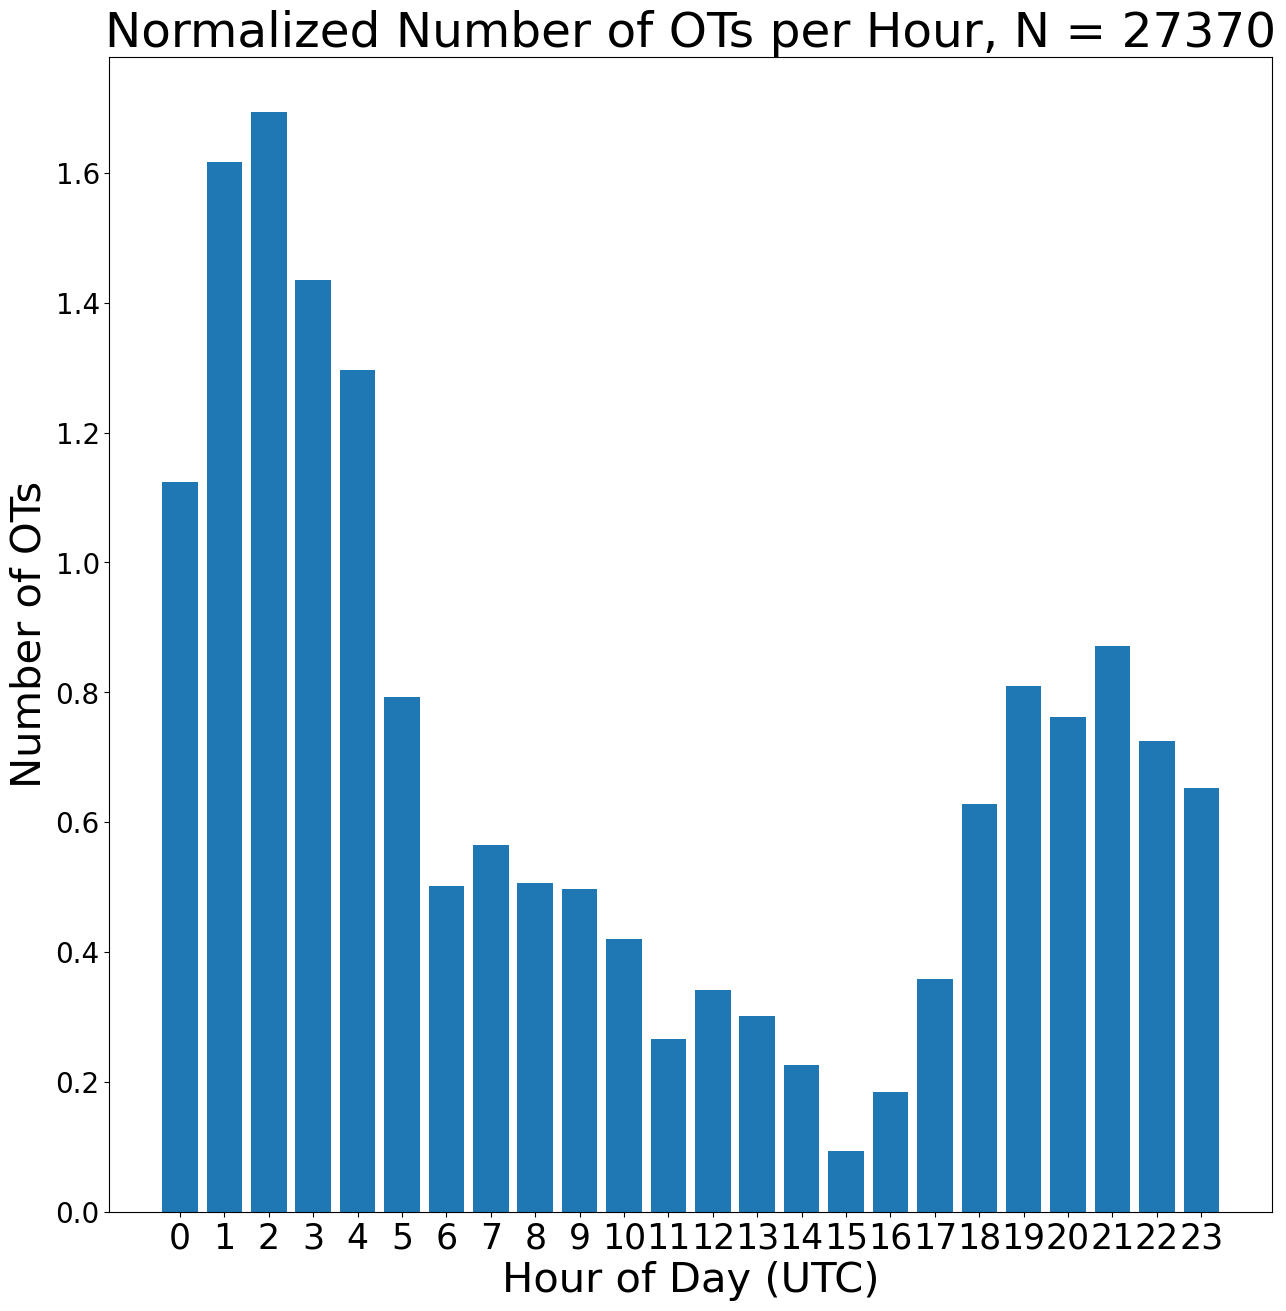

In [85]:
fig, ax = plt.subplots(figsize = (15,15))
plt.bar(hrs, files_normed)
plt.title('Normalized Number of OTs per Hour, N = %0.0f'%sum_cph, fontsize = 35)
plt.xlabel('Hour of Day (UTC)', fontsize = 30)
plt.ylabel('Number of OTs', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 20)
ax.set_xticks(hrs)

In [57]:
grouped_by_day = gpd_jan25.groupby(gpd_jan25.index)
date_list = list(grouped_by_day.groups.keys())

In [61]:
date_list[390:400]

[Timestamp('2018-11-10 22:00:55.000000512'),
 Timestamp('2018-11-10 22:01:55.000000512'),
 Timestamp('2018-11-10 22:02:54.999999488'),
 Timestamp('2018-11-10 22:03:55.000000512'),
 Timestamp('2018-11-10 22:04:55.000000512'),
 Timestamp('2018-11-10 22:05:54.999999488'),
 Timestamp('2018-11-10 22:06:54.999999488'),
 Timestamp('2018-11-10 22:07:55.000000512'),
 Timestamp('2018-11-10 22:08:55.000000512'),
 Timestamp('2018-11-10 22:09:54.999999488')]

In [63]:
import matplotlib.animation as anim
import glob
lat_track = []
lon_track = []
ot_dict = {}
for i in date_list[395:410]:
    fig, ax = plt.subplots(figsize= (12,12))
    file = glob.glob(f"/data/accp/a/snesbitt/arm/goesV2/cor1goecnvv2X1.a1.{i:%Y%m%d.%H%M}*.cdf")
    test_file = xr.open_dataset(file[0])
    ir_temps = test_file.ir_brightness_temperature[0].values
    lons = test_file.longitude.values
    lats = test_file.latitude.values
    plt.pcolormesh(lons, lats, ir_temps, cmap = rev_map)
    plt.title(pd.to_datetime(test_file.time.values[0]).strftime('%d %b %y %H:%M:%S'), fontsize=30)
    plt.ylim(-31.7, -32.7)
    plt.xlim(-64, -63)

    filtered_gpd = gpd_jan25[gpd_jan25.index == i]
    grouped_filts = filtered_gpd.groupby('cell')
    ot_id = list(grouped_filts.groups.keys())
    

    for id in ot_id:
        otids = list(ot_dict.keys())
        lat, lon = grouped_filts.get_group(id).lat.values, grouped_filts.get_group(id).lon.values
        if str(int(id)) in otids:
            ot_dict[f"{int(id)}"]['lats'].extend([np.squeeze(lat).tolist()])
            ot_dict[f"{int(id)}"]['lons'].extend([np.squeeze(lon).tolist()])
        else:
            ot_dict[f"{int(id)}"] = {"lats": [], "lons": []}
            ot_dict[f"{int(id)}"]['lats'] = [np.squeeze(lat).tolist()]
            ot_dict[f"{int(id)}"]['lons'] = [np.squeeze(lon).tolist()]
        
    for k in list(ot_dict.keys()):
        lat = ot_dict[k]['lats']
        lons = ot_dict[k]['lons']
    
        ax.plot(lons, lat, 'o-', markersize = 0.5)
        #ax.set_xlim([-66, -62])
        #ax.set_ylim([-36, -32])
        #ot_dict[f"{id}"] = {'lats': [], 'lons': []}    
    plt.savefig(f'ot_{i:%Y%m%d.%H%M}.png')
    plt.close()